# [ADA-2020]: P4-milestone
### Group project: Friendship and home position

**Objective**: Inspect the difference in quantity, quality and distribution of friends according to where a person lives

**Authors**: ADA Dream Team

**Study paper**: Eunjoon Cho, Seth A. Myers and Jure Leskovec, *Friendship and Mobility: User Movement in Location-Based Social Network*, Standford University, 2011

**Datasets**:
1. Gowalla dataset: https://snap.stanford.edu/data/loc-gowalla.html. A dataset from the paper. Checkins of users and friends relationship.
2. Brightkite dataset: https://snap.stanford.edu/data/loc-Brightkite.html. A dataset from the paper. Checkins of users and friends relationship.
3. Compilation of UNData: https://www.kaggle.com/sudalairajkumar/undata-country-profiles. Different characteristics for each country.
4. Compilation of USGovt: https://www.kaggle.com/fernandol/countries-of-the-world. More characteristics for each country.
5. happiness2020.pkl and countries_info.csv from "tutorial 01- Handling data", extracted from the World Happiness Report of the United Nations Sustainable Development Solution Network. More characteristics for each country.

**Method**: The method that will be used here is the following:

<span style="color:red">!! ADD WHOLE METHOD (SUMMARY)!!</span>

**Others**: 
The abstract as well as the research questions can be found on the README.md.

In [140]:
#Librairies

#General purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

#Convert country names to ISO codes
import pycountry 
import pycountry_convert 

#Convert longitudes and latitudes to country
import reverse_geocoder 

#Plot country map
import cartopy 
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.wkt as wkt
from shapely.geometry import MultiPolygon

#Handle colors
import matplotlib.cm as cm
import matplotlib.colors as mcolors

#Library to normalize/standarize values
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

#Statistical tests
from bioinfokit.analys import stat
from scipy import stats

#ML mehtods
from sklearn.mixture import GaussianMixture # clustering
import statsmodels.formula.api as smf       # regression
from pca import pca                         # principal component analysis

In [2]:
#Global constants
PATH = "data/"

## 0. Extraction of the data, preprocessing and merge
In this section, the different dataset will be loaded and preprocessed. Preprocess is the same as the one presented in the tutorial and in our previous milestone. The countries dataset will be merged together to form a big dataset with all the data about each country.

### 0.1 Users dataset
Gowalla and Brightkite are social networks. Their dataset are composed of checkins of each users (place, date, ...) and their friendship relations.

In [3]:
#Extraction parameters
EXTENSION = ".txt.gz"
SEPARATOR = "\t"
CHECKIN_COLUMNS_NAME = ["user", "check-in time", "latitude", "longitude", "location id"]
EDGE_COLUMNS_NAME = ["friend1", "friend2"]
#Extract dataframe from .txt.gz (tabulated separated without header)
user = "IDS"
if user == "ANDRES":
    gowalla_edges = pd.read_csv(PATH+"Gowalla_edges.csv", sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    gowalla_checkins = pd.read_csv(PATH+"Gowalla_totalCheckins.csv", sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
    bright_edges = pd.read_csv(PATH+"Brightkite_edges.csv", sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    bright_checkins = pd.read_csv(PATH+"Brightkite_totalCheckins.csv", sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
elif user == "IDS":
    bright_edges = pd.read_csv(PATH+"loc-brightkite_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    bright_checkins = pd.read_csv(PATH+"loc-brightkite_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
    gowalla_edges = pd.read_csv(PATH+"loc-gowalla_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    gowalla_checkins = pd.read_csv(PATH+"loc-gowalla_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
else:
    bright_edges = pd.read_csv(PATH+"loc-brightkite_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    bright_checkins = pd.read_csv(PATH+"loc-brightkite_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
    gowalla_edges = pd.read_csv(PATH+"loc-gowalla_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    gowalla_checkins = pd.read_csv(PATH+"loc-gowalla_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)


#Remove from checkin some invalid points (null data and incoherent latitudes)
bright_0_lat = bright_checkins[bright_checkins["latitude"] == 0]
bright_0_lat_long = bright_0_lat[bright_0_lat["longitude"] == 0]
bright_checkins = bright_checkins.drop(bright_0_lat_long.index)
bright_big_lat = bright_checkins[bright_checkins["latitude"]>90]
bright_checkins = bright_checkins.drop(bright_big_lat.index)
bright_small_lat = bright_checkins[bright_checkins["latitude"]<-90]
bright_checkins = bright_checkins.drop(bright_small_lat.index)

gowalla_0_lat = gowalla_checkins[gowalla_checkins["latitude"] == 0]
gowalla_0_lat_long = gowalla_0_lat[gowalla_0_lat["longitude"] == 0]
gowalla_checkins = gowalla_checkins.drop(gowalla_0_lat_long.index)
gowalla_big_lat = gowalla_checkins[gowalla_checkins["latitude"]>90]
gowalla_checkins = gowalla_checkins.drop(gowalla_big_lat.index)
gowalla_small_lat = gowalla_checkins[gowalla_checkins["latitude"]<-90]
gowalla_checkins = gowalla_checkins.drop(bright_small_lat.index)

#Sample dataframe to analyze and verify structure
#bright_edges.sample(1)
bright_checkins.sample(1)
#gowalla_edges.sample(1)
#gowalla_checkins.sample(1)

,user,check-in time,latitude,longitude,location id
4671930,53129,2008-10-22T06:14:02Z,33.772537,-84.384439,a49e63069f1111ddb31b003048c0801e


### 0.2 Countries dataset
Three different dataset with informations about countries will be used. The first one is from the World Happiness Report of the United Nations Sustainable Development Solution Network, it was presented in the Tutorial of this class; it will be refered as country_WHR (for World Happiness Report). The second one is a compilation (from https://www.kaggle.com/sudalairajkumar/undata-country-profiles) of data from the UN (http://data.un.org/); it will refered as country_UN. The last one is also a compilation (https://www.kaggle.com/fernandol/countries-of-the-world) of data from the CIA (https://www.cia.gov/library/publications/the-world-factbook/); it will be refered as country_CIA.

First, we load and preprocess each one. Then we merge all their information into a big dataset; countries_features.

#### 0.2.1  World Happiness Report (WHR)

In [4]:
#Load data
countries = pd.read_csv(PATH+"countries_info.csv")
happiness = pd.read_pickle(PATH+"happiness2020.pkl")

#Lower case countries from happiness so merge will be possible
happiness["country"] = happiness["country"].str.lower()
#Change column name so they will merge (not duplicated) #!may exist a simpler alternative in the merge options
names = countries.columns.tolist()
names[names.index("country_name")] = "country"
countries.columns = names
#Merge
country_WHR = pd.merge(happiness, countries, left_on = "country", right_on = "country")

#Drop the columns if there is an invalid data (we won't be able to use feature if not all country have it)
country_WHR = country_WHR.dropna(axis = 1)

#Restore first letter as upper case for latter use
country_WHR.country = country_WHR.country.str.title()

#Sample dataframe to analyze and verify structure
country_WHR.sample(1)

,country,happiness_score,social_support,healthy_life_expectancy,freedom_of_choices,generosity,perception_of_corruption,world_region,area,population
31,Denmark,7.6456,0.955991,72.402504,0.951444,0.066202,0.168489,Western Europe,43094,5450661


#### 0.2.2  United Nation Compilation (UN)

In [5]:
#Converts the ratio string ("x/y") to the corresponding float
def string_div_to_float(my_string):
    try:
        num, denom = my_string.split('/')
        return float(num) / float(denom)
    except ValueError: #some of the data have ".../..." as a ratio...
        return -100

In [6]:
#Load data (Some datasets represents ratio as such strings "x/y", we will convert it with a float resulting of the division)
country_UN = pd.read_csv(PATH+"country_profile_variables.csv", converters={"Labour force participation (female/male pop. %)":string_div_to_float, "Life expectancy at birth (females/males, years)":string_div_to_float,"Education: Primary gross enrol. ratio (f/m per 100 pop.)":string_div_to_float, "Education: Tertiary gross enrol. ratio (f/m per 100 pop.)":string_div_to_float,"Population age distribution (0-14 / 60+ years, %)":string_div_to_float, "Forested area (% of land area)":string_div_to_float,"Education: Secondary gross enrol. ratio (f/m per 100 pop.)":string_div_to_float,"International migrant stock (000/% of total pop.)":string_div_to_float,"Energy supply per capita (Gigajoules)":string_div_to_float,"Pop. using improved drinking water (urban/rural, %)":string_div_to_float})

#Treat some aberrations
country_UN = country_UN.replace("~0.0",0)
country_UN = country_UN.replace("...",np.nan)

#Drop the columns if there is an invalid data (we won't be able to use feature if not all country have it)
country_UN = country_UN.dropna(axis = 1)

#Remove Guadeloupe and Mayotte that are french
country_UN = country_UN[country_UN.country != "Guadeloupe"]
country_UN = country_UN[country_UN.country != "Mayotte"]

#Sample dataframe to analyze and verify structure
country_UN.sample(1)

,country,Region,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",GDP per capita (current US$),Economy: Agriculture (% of GVA),...,Education: Tertiary gross enrol. ratio (f/m per 100 pop.),Seats held by women in national parliaments %,Individuals using the Internet (per 100 inhabitants),Threatened species (number),Forested area (% of land area),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)",Net Official Development Assist. received (% of GNI)
59,Dominica,Caribbean,750,74,98.6,103.0,512,-1.8,7051.1,15.4,...,-100.0,25.0,66,58.1,0.052632,0,29,-100.0,-100.0,-99


#### 0.2.3  Central Intelligence Agency Compilation (CIA)

In [7]:
#Load data
country_CIA = pd.read_csv(PATH+"countries of the world.csv")

#Same country index name
country_CIA = country_CIA.rename(columns = {"Country":"country"})

#Change commas with dot
country_CIA = country_CIA.stack().str.replace(',','.').unstack()

#Remove Guadeloupe and Mayotte that are french and Virgin Islands that are american
country_CIA = country_CIA[country_CIA.country != "Guadeloupe "]
country_CIA = country_CIA[country_CIA.country != "Mayotte "]
country_CIA = country_CIA[country_CIA.country != "Virgin Islands "]

#Drop the columns if there is an invalid data (we won't be able to use feature if not all country have it)
country_CIA = country_CIA.dropna(axis = 1)

#Sample dataframe to analyze and verify structure
country_CIA.sample(1)

,country,Region,Pop. Density (per sq. mi.),Coastline (coast/area ratio)
43,Colombia,LATIN AMER. & CARIB,38.3,0.28


#### 0.2.4 Merge the three datasets
The three datasets will be merged in this section. To be able to merge them we need a common identifier, to do so we use the pycountry library. We did not found a library able to work with pandas so we have to do a lambda iteration, which is reasonable as the number of countries is not incredeibly large and we only do it once. 

Note that the WHR dataset is smaller than the two others. Also note that during this conversion some countries are not correctly identified and so are removed, however these countries are in most cases small islands or countries in development which may have very little nor no data for the networks dataset.

In [8]:
#from https://codereview.stackexchange.com/questions/238714/basic-function-to-convert-country-name-to-iso-code-using-pycountry
# convert country name in alpha 3 name
def country_to_alpha3(country):
    try:
        result = pycountry.countries.search_fuzzy(country)
    except Exception:
        return np.nan
    else:
        return result[0].alpha_3

#Convert the name of a country to alpha 2 code
def country_to_alpha2(country):
    try:
        result = pycountry_convert.country_name_to_country_alpha2(country)
    except Exception:
        result = np.nan
    return result

In [9]:
#Create a table to convert country - alpha 3 and alpha 2 : ALPHA3 will be used as much as possible
countries_names = country_UN.country.unique()
countries_alpha2 = np.array([country_to_alpha2(country) for country in countries_names])
countries_alpha3 = np.array([country_to_alpha3(country) for country in countries_names])

#Group them
country_translator = pd.DataFrame(data = {"country":countries_names,"alpha2":countries_alpha2,"alpha3":countries_alpha3})

#Send Nigeria and Niger to invalid country because they have the same alpha3 (same for worst and best Korea)
country_translator = country_translator[country_translator.alpha3 != "PRK"]
country_translator = country_translator[country_translator.alpha3 != "NGA"]

#Drop a country if it has no code associated
country_translator = country_translator.replace("nan",np.nan).dropna()

#Example
country_translator.sample(1)

,country,alpha2,alpha3
165,Russian Federation,RU,RUS


In [10]:
#Create a function that given an array of alpha2 returns an array of alpha3
def alpha2_to_alpha3(alpha2s):
    df = pd.DataFrame({"alpha2" : alpha2s})
    #Merge the dataset
    res = df.merge(country_translator, left_on = "alpha2", right_on = "alpha2", how="left")
    #Remove the added columns
    return res["alpha3"].astype("string")

In [11]:
#Change country names to alpha3 so they can be compared  (we cannot use the table because names maybe differents)
country_WHR['alpha3'] = country_WHR.country.apply(lambda name: country_to_alpha3(name))
country_UN['alpha3'] = country_UN.country.apply(lambda name: country_to_alpha3(name))
country_CIA['alpha3'] = country_CIA.country.apply(lambda name: country_to_alpha3(name))

#Remove the countries that received invalid alpha3 number
country_WHR = country_WHR.dropna()
country_UN = country_UN.dropna()
country_CIA = country_CIA.dropna()
#Nigeria and Niger have the same alpha3 code
country_WHR = country_WHR[country_WHR.alpha3 != "NGA"] 
country_UN = country_UN[country_UN.alpha3 != "NGA"]
country_CIA = country_CIA[country_CIA.alpha3 != "NGA"]
#Same for best and worst Korea
country_WHR = country_WHR[country_WHR.alpha3 != "PRK"] 
country_UN = country_UN[country_UN.alpha3 != "PRK"]
country_CIA = country_CIA[country_CIA.alpha3 != "PRK"]
#Remove the information repeated accross datasets
TO_REMOVE_WHR = ["healthy_life_expectancy", "world_region", "area", "population","country"]
TO_REMOVE_CIA = ["Region","country","Pop. Density (per sq. mi.)"]
TO_REMOVE_UN = ["country"]
country_WHR = country_WHR.drop(columns = TO_REMOVE_WHR)
country_CIA = country_CIA.drop(columns = TO_REMOVE_CIA)
country_UN = country_UN.drop(columns = TO_REMOVE_UN)

In [12]:
#Merge the different datasets
countries_features = country_WHR.merge(country_UN, left_on = "alpha3", right_on = "alpha3", how="inner")
countries_features = countries_features.merge(country_CIA, left_on = "alpha3", right_on = "alpha3", how="inner")

#Sample dataframe to analyze and verify structure
countries_features.sample(4)

,happiness_score,social_support,freedom_of_choices,generosity,perception_of_corruption,alpha3,Region,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)",...,Seats held by women in national parliaments %,Individuals using the Internet (per 100 inhabitants),Threatened species (number),Forested area (% of land area),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)",Net Official Development Assist. received (% of GNI),Coastline (coast/area ratio)
96,3.3123,0.540835,0.900589,0.055484,0.183541,RWA,EasternAfrica,26338,12208,494.9,...,61.3,62,19.2,8.000000,84,8,1.204451,0.930048,-99,0.00
105,6.4009,0.921125,0.751990,-0.050962,0.765860,ESP,SouthernEurope,505944,46354,92.9,...,39.1,617,36.8,45.882353,1432,102,1.000000,0.998000,-99,0.98
0,2.5669,0.470367,0.396573,-0.096429,0.933687,AFG,SouthernAsia,652864,35530,54.4,...,27.7,42,2.1,32.666667,63,5,1.663830,1.670370,-99,0.00
23,5.1239,0.798761,0.898518,-0.181426,0.753971,CHN,EasternAsia,9600000,1409517,150.1,...,23.7,1080,22.0,1372.253333,101394,87,1.048387,1.359498,-99,0.15


From all the features we remove the ones that we consider uninteresting for our application or repeated in different ways (density of population and total population).

In [13]:
TO_REMOVE = ["Surface area (km2)","GDP: Gross domestic product (million current US$)", "Economy: Agriculture (% of GVA)","Economy: Industry (% of GVA)", "Economy: Services and other activity (% of GVA)","Agricultural production index (2004-2006=100)","Food production index (2004-2006=100)","Seats held by women in national parliaments %","Threatened species (number)","CO2 emission estimates (million tons/tons per capita)","Energy production, primary (Petajoules)","Pop. using improved drinking water (urban/rural, %)","Net Official Development Assist. received (% of GNI)"]
countries_features = countries_features.drop(columns=TO_REMOVE)

In the end, we have a dataset with 127 countries (there was 131 valid countries in the WHR dataset). In total there is 26 columns. So there is 25 features for each country, they are:

In [14]:
features_global = countries_features.columns
for feature in features_global:
    if(feature != "country" and feature != "alpha3_name"):
        print(feature)

happiness_score
social_support
freedom_of_choices
generosity
perception_of_corruption
alpha3
Region
Population in thousands (2017)
Population density (per km2, 2017)
Sex ratio (m per 100 f, 2017)
GDP growth rate (annual %, const. 2005 prices)
GDP per capita (current US$)
Labour force participation (female/male pop. %)
Population growth rate (average annual %)
Urban population (% of total population)
Urban population growth rate (average annual %)
Life expectancy at birth (females/males, years)
Population age distribution (0-14 / 60+ years, %)
International migrant stock (000/% of total pop.)
Health: Total expenditure (% of GDP)
Education: Primary gross enrol. ratio (f/m per 100 pop.)
Education: Secondary gross enrol. ratio (f/m per 100 pop.)
Education: Tertiary gross enrol. ratio (f/m per 100 pop.)
Individuals using the Internet (per 100 inhabitants)
Forested area (% of land area)
Energy supply per capita (Gigajoules)
Coastline (coast/area ratio)


The country in our dataset are represented above (code copied by https://github.com/SciTools/cartopy/issues/1303 and exception error by https://stackoverflow.com/questions/63943614/python-cartopy-how-to-solve-polygon-object-error):

In [15]:
#Color a counter (indicated by its ISO code) in a color
def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                                  alpha = 1.00, linewidth =0.15, edgecolor = "black",
                                  label=n.attributes['ADM0_A3']) 
            except Exception as e:
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr, 
                                  alpha = 1.00, linewidth =0.15, edgecolor = "black",
                                  label=n.attributes['ADM0_A3']) 
            return ax

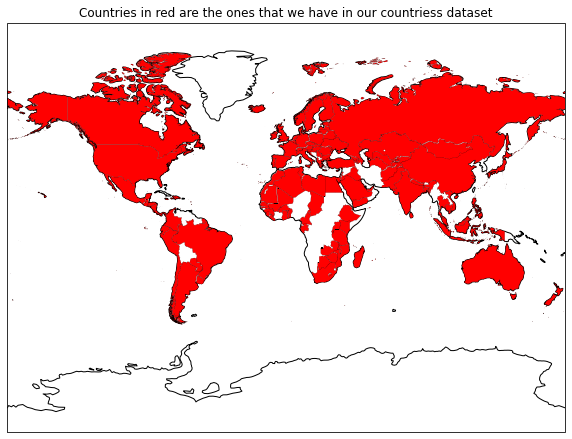

In [16]:
#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for n in countries_features.alpha3 :
    area(ax, n, "red")
    
plt.title("Countries in red are the ones that we have in our countriess dataset")
plt.show()

## 1. Compute home position
Average the home position of the users. This is done like explained in the paper. The implementation is exactly the same as what was done for P2-milestone and so here we just load the result. The jupyter notebook that explain this can be found in the git under the name "replication_report".

In [17]:
gowalla_home_pos_light = pd.read_csv(PATH+"g_home.csv").set_index("user")
bright_home_pos_light = pd.read_csv(PATH+"b_home.csv").set_index("user")

In [18]:
#Sample dataframe to analyze and verify structure
#bright_home_pos_light.sample(4)
gowalla_home_pos_light.sample(4)

,lat,long
user,,
19533,52.314297,4.862839
161597,59.313570,18.076133
10062,59.336764,18.052843
31659,39.985641,-82.997432


## 2. Compute nationality and remove non used countries

### 2.1 Compute nationality of the users
Convert longitude latitude to country. To do so we use the reverse_geocoder library.

In [19]:
#Create new dataset
bright_home_complete = bright_home_pos_light
gowalla_home_complete = gowalla_home_pos_light

#Convert long-lat peer in tupple so it is easier for the library
bright_longlat_tupple = list(zip(bright_home_pos_light.lat, bright_home_pos_light.long))
gowalla_longlat_tupple = list(zip(gowalla_home_pos_light.lat, gowalla_home_pos_light.long))

#Search the localisation of each datapoint
bright_home_complete["loc"] = reverse_geocoder.search(bright_longlat_tupple)
gowalla_home_complete["loc"] = reverse_geocoder.search(gowalla_longlat_tupple)

#Separate the localisation information in the different part (name of the city, admin district, country code)
bright_home_complete = pd.DataFrame(bright_home_complete['loc'].tolist(), index=bright_home_complete.index)
gowalla_home_complete = pd.DataFrame(gowalla_home_complete['loc'].tolist(), index=gowalla_home_complete.index)

#Convert country code to country name
bright_home_complete["alpha3"] = alpha2_to_alpha3(bright_home_complete.cc)
gowalla_home_complete["alpha3"] = alpha2_to_alpha3(gowalla_home_complete.cc)

#Remove if a country is not represented by an alpha3 value
bright_home_complete = bright_home_complete.dropna()
gowalla_home_complete = gowalla_home_complete.dropna()

#Remove the useless columns
TO_REMOVE = ["name","admin1","admin2","cc","lat","lon"]
bright_nat = bright_home_complete.drop(columns = TO_REMOVE)
gowalla_nat = gowalla_home_complete.drop(columns = TO_REMOVE)

TO_REMOVE = ["name","admin1","admin2","lat","lon"]
bright_cc = bright_home_complete.drop(columns = TO_REMOVE)
gowalla_cc = gowalla_home_complete.drop(columns = TO_REMOVE)

#Sample dataframe to analyze and verify structure
bright_nat.sample(4)
#gowalla_nat.sample(4)

Loading formatted geocoded file...


,alpha3
user,
30673,USA
21495,USA
26977,USA
14293,USA


### 2.2 Find less used countries and remove them
To decide whatever we keep or not a country we compute its users density (sum of the two applications). 

The minimum density is set to 1 person over 100'000 in one country that have th application. It may seem very few, however the dataset has very low density for all countries (see plot and description above, only green are availible with our density) and we need to have at least some countries to compare.

<span style="color:red">DISCUSS THIS CHOICE</span> 

In [20]:
#Count the users of each country
bright_countries_count = bright_nat.alpha3.value_counts()
gowalla_countries_count = gowalla_nat.alpha3.value_counts()

In [21]:
#Do a safety guard
countries_features_temp = countries_features

#Add the number of users to the countries features and remove
countries_features_temp = countries_features_temp.merge(bright_countries_count, left_on = "alpha3", right_index = True, how = "left")
countries_features_temp = countries_features_temp.rename(columns = {"alpha3_x":"alpha3"})
countries_features_temp = countries_features_temp.rename(columns = {"alpha3_y":"bright_count"})
countries_features_temp = countries_features_temp.merge(gowalla_countries_count, left_on = "alpha3", right_index = True, how = "left")
countries_features_temp = countries_features_temp.rename(columns = {"alpha3_x":"alpha3"})
countries_features_temp = countries_features_temp.rename(columns = {"alpha3_y":"gowalla_count"})

#Replace the NaN values to 0
countries_features_temp = countries_features_temp.fillna(0)

#Sum the users of each application
countries_features_temp["users"] = countries_features_temp["bright_count"] + countries_features_temp["gowalla_count"]
#Compute the density of users in the population
countries_features_temp["density_users"] = countries_features_temp["users"]/(countries_features_temp["Population in thousands (2017)"]*1000)

In [22]:
countries_features_temp

,happiness_score,social_support,freedom_of_choices,generosity,perception_of_corruption,alpha3,Region,Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",...,Education: Secondary gross enrol. ratio (f/m per 100 pop.),Education: Tertiary gross enrol. ratio (f/m per 100 pop.),Individuals using the Internet (per 100 inhabitants),Forested area (% of land area),Energy supply per capita (Gigajoules),Coastline (coast/area ratio),bright_count,gowalla_count,users,density_users
0,2.5669,0.470367,0.396573,-0.096429,0.933687,AFG,SouthernAsia,35530,54.4,106.3,...,0.561528,0.278195,42,32.666667,1.663830,0.00,1,0,1,2.814523e-08
1,4.8827,0.671070,0.781994,-0.042309,0.896304,ALB,SouthernEurope,2930,106.9,101.9,...,0.936235,1.398357,130,2.850000,0.996849,1.26,0,1,1,3.412969e-07
2,5.0051,0.803385,0.466611,-0.121105,0.735485,DZA,NorthernAfrica,41318,17.3,102.0,...,1.036697,1.560554,135,39.297297,1.030562,0.04,8,0,8,1.936202e-07
3,5.9747,0.900568,0.831132,-0.194914,0.842010,ARG,SouthAmerica,44271,16.2,95.9,...,1.066731,1.620472,256,43.404255,0.990000,0.18,59,34,93,2.100698e-06
4,4.6768,0.757479,0.712018,-0.138780,0.773545,ARM,WesternAsia,2930,102.9,88.8,...,1.010216,1.127404,114,3.055556,1.000000,0.00,0,0,0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,6.2576,0.926596,0.974998,0.248427,0.501497,UZB,CentralAsia,31911,75.0,99.4,...,0.982438,0.645455,59,29.222222,1.217553,0.00,1,1,2,6.267431e-08
123,5.3535,0.849987,0.939593,-0.094533,0.796421,VNM,South-easternAsia,95541,308.1,98.0,...,-100.000000,1.003472,616,92.722222,1.022704,1.05,24,48,72,7.536032e-07
124,3.5274,0.817981,0.599920,-0.157735,0.800288,YEM,WesternAsia,28250,53.5,102.1,...,0.688153,0.445255,298,25.222222,1.548387,0.36,0,0,0,0.000000e+00
125,3.7594,0.698824,0.806500,0.078037,0.801290,ZMB,EasternAfrica,17094,23.0,98.5,...,-100.000000,0.755556,88,15.000000,1.668616,0.00,3,0,3,1.755002e-07


count      127.000000
mean       820.818898
std       5235.343624
min          0.000000
25%          2.000000
50%         15.000000
75%        188.000000
max      57879.000000
Name: users, dtype: float64


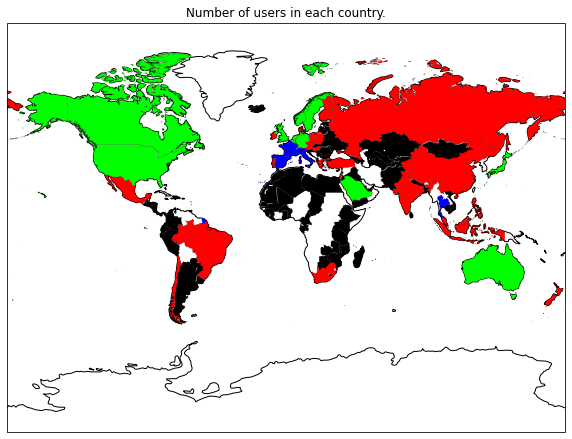

In [23]:
# Plot the number of users distribution
temp = countries_features_temp.copy()

#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for index, t in temp.iterrows() :
    color = (0,0,0)
    if(t.users > 1000):
        color = (0,1,0)
    elif(t.users > 500):
        color = (0,0,1)
    elif(t.users > 100):
        color = (1,0,0)
    area(ax, t.alpha3, color)
    
plt.title("Number of users in each country.")
print(temp.users.describe())

In [24]:
#Remove the countries that have less than 100 users (incoherent results even if enough density)
countries_features_temp = countries_features_temp[countries_features_temp.users > 100]

count    4.000000e+01
mean     7.627885e-05
std      1.729279e-04
min      2.165504e-07
25%      8.363802e-06
50%      2.803308e-05
75%      7.970267e-05
max      1.017455e-03
Name: density_users, dtype: float64


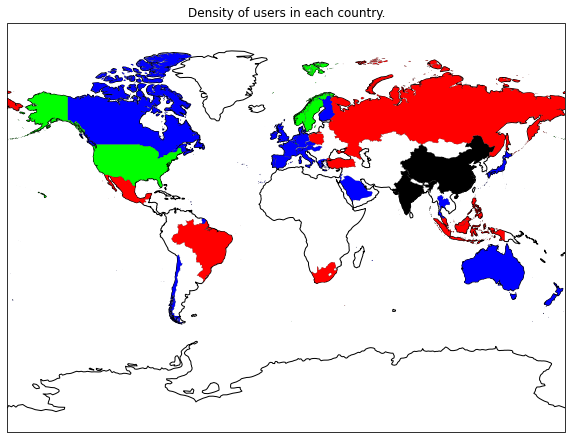

In [25]:
# Plot the density distribution (add Alpha 3 just for the plot)
temp = countries_features_temp.copy()

#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for index, t in temp.iterrows() :
    color = (0,0,0)
    if(t.density_users > 1e-4):
        color = (0,1,0)
    elif(t.density_users > 1e-5):
        color = (0,0,1)
    elif(t.density_users > 1e-6):
        color = (1,0,0)
    area(ax, t.alpha3, color)
    
plt.title("Density of users in each country.")
print(temp.density_users.describe())

In [26]:
#Parameter
MIN_DENSITY = 1e-5

#keep only the countries that have a minimum density of users
countries_features_clean = countries_features_temp[countries_features_temp["density_users"] > MIN_DENSITY]
valid_countries_alpha3 = countries_features_clean.alpha3.values

#Remove the useless columns
TO_REMOVE = ["bright_count", "gowalla_count","users","density_users","Population in thousands (2017)"]
countries_features_clean = countries_features_clean.drop(columns = TO_REMOVE)

#Sample dataframe to analyze and verify structure
countries_features_clean.sample(4)

,happiness_score,social_support,freedom_of_choices,generosity,perception_of_corruption,alpha3,Region,"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)","GDP growth rate (annual %, const. 2005 prices)",...,"Population age distribution (0-14 / 60+ years, %)",International migrant stock (000/% of total pop.),Health: Total expenditure (% of GDP),Education: Primary gross enrol. ratio (f/m per 100 pop.),Education: Secondary gross enrol. ratio (f/m per 100 pop.),Education: Tertiary gross enrol. ratio (f/m per 100 pop.),Individuals using the Internet (per 100 inhabitants),Forested area (% of land area),Energy supply per capita (Gigajoules),Coastline (coast/area ratio)
48,6.0004,0.921934,0.718965,-0.194323,0.892917,HUN,EasternEurope,107.4,90.7,3.1,...,0.550000,97.739130,7.4,0.994112,1.001903,1.251656,66,9.790698,1.0,0.00
55,6.3874,0.889879,0.664652,-0.043461,0.873405,ITA,SouthernEurope,201.8,95.1,0.7,...,0.459184,596.793814,9.2,0.992110,0.976945,1.357143,359,59.333333,1.0,2.52
86,7.4880,0.952487,0.955750,0.134533,0.263218,NOR,NorthernEurope,14.5,101.8,1.6,...,0.798206,52.239437,9.7,0.998010,0.968614,1.457006,64,5.173913,1.0,7.77
84,7.2996,0.949119,0.936217,0.191598,0.221139,NZL,Oceania,17.9,96.7,3.1,...,0.951923,45.204348,11.0,0.994980,1.057319,1.350559,199,4.506494,1.0,5.63


In [27]:
#Create a min max version of the dataset (useful for plots)
scaler = MinMaxScaler()
countries_features_0_1 = countries_features_clean.copy()

for column in countries_features_0_1.columns:
    if column != "alpha3" and column != "Region":
        countries_features_0_1[column] = scaler.fit_transform((countries_features_0_1[column].values).reshape(-1,1))


#Create a standarize version of the dataset (useful for ML)
scaler = preprocessing.StandardScaler()
countries_features_std = countries_features_clean.copy()
for column in countries_features_std.columns:
    if column != "alpha3"  and column != "Region":
        countries_features_std[column] = scaler.fit_transform((countries_features_std[column].values).reshape(-1,1))

There are 40 countries availible.


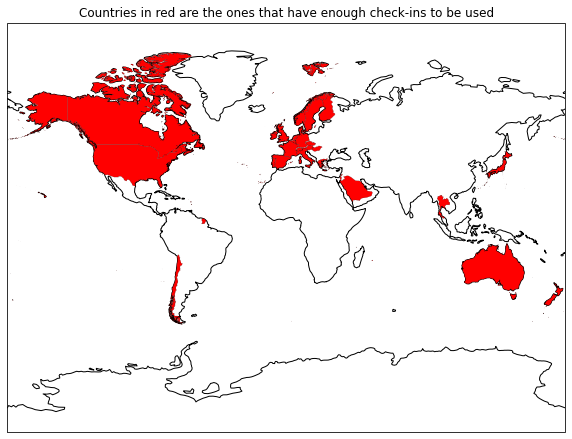

In [28]:
# Plot the countries in the final dataset (add Alpha 3 just for the plot)
temp = countries_features_clean

#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for n in temp.alpha3 :
    area(ax, n, "red")
    
plt.title("Countries in red are the ones that have enough check-ins to be used")
print("There are "+str(countries_features_temp.shape[0])+" countries availible.")
plt.show()

The final number of country is low, but we have to have meaningful results.

### 2.3 Cluster the countries
Try to find if some groups emerge from the countries' features. First data will be normalized (with a StandrardScaler), then we will use k-means with a set of k-values to find the optimal number of clusters. Finally, we show the emerging clusters.

In [29]:
#Generate a list of colors for the plots
colors = mcolors.BASE_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name) for name, color in colors.items())
color_names = [name for hsv, name in by_hsv]
color_names.remove("w") #pop white
color_names.extend(["gray","brown","orange","lightgreen","cyan","beige","pink","navy","tan","lime","royalblue","brown","moccasin","deeppink","magenta","slategrey","dodgerblue","oldlace"])
NB_MAX_GRP = len(color_names)

In [30]:
#Save the indetificators that we need
countires_codes = countries_features_std.alpha3

#Remove the information that can not be used for clustering
TO_REMOVE = ["alpha3","Region"]
country_clustering = countries_features_std.drop(columns=TO_REMOVE)

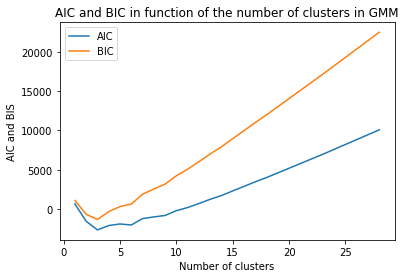

In [31]:
#Initialize the variables
all_aic = []
all_bic = []
NB_MAX_CENTROIDS = len(countires_codes)

#Evaluate the root mean square (RMS) with different values of k
for nb_centroids in range(1, NB_MAX_CENTROIDS):
    gmm = GaussianMixture(n_components=nb_centroids, n_init = 50, init_params = "kmeans").fit(country_clustering)
    all_aic.append(gmm.aic(country_clustering))
    all_bic.append(gmm.bic(country_clustering))
    
    
#Plot the result
plt.plot(np.arange(1,NB_MAX_CENTROIDS), all_aic, label = "AIC")
plt.plot(np.arange(1,NB_MAX_CENTROIDS), all_bic, label = "BIC")
plt.title("AIC and BIC in function of the number of clusters in GMM")
plt.xlabel("Number of clusters")
plt.ylabel("AIC and BIS")
plt.legend()

From the plot we see that the minimum for both occurs around 3 to 5 clusters.

In [32]:
#Compute with our best resut
BEST_NB_CLUSTERS = 4
gmm = GaussianMixture(n_components=BEST_NB_CLUSTERS, n_init = 100, init_params = "kmeans").fit(country_clustering)
labels = gmm.fit_predict(country_clustering)
res = pd.DataFrame(index = countires_codes, data = labels, columns =["labels"])

In [33]:
#Print the countries in each cluster
for lab in np.unique(labels):
    print("Label n°"+str(lab))
    print(res[res.labels == lab].index.values)

features_clusters = res

Label n°0
['SGP']
Label n°1
['AUT' 'BEL' 'CAN' 'FRA' 'DEU' 'IRL' 'GBR' 'USA']
Label n°2
['CHL' 'CZE' 'GRC' 'HUN' 'ITA' 'JPN' 'PRT' 'SAU' 'ESP' 'THA']
Label n°3
['AUS' 'DNK' 'FIN' 'ISR' 'LUX' 'NLD' 'NZL' 'NOR' 'SWE' 'CHE']


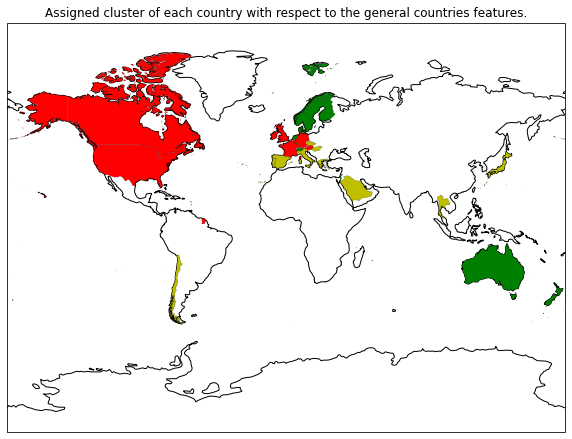

In [34]:
#Create the world for the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

#Extract the clusters
clusters = np.unique(labels)
nb_cluster = np.max(clusters)

#Plot
if(nb_cluster > NB_MAX_GRP): #Some clusters cannot be plotted
    print("COLORS ARE REPEATING")
else:
    for i in range(0, len(labels)) :
        label = labels[i]
        color = color_names[label]
        area(ax, countires_codes.iloc[i], color)

    plt.title("Assigned cluster of each country with respect to the general countries features.")

## 3. Friends charachteristics

### 3.1 Compute Quantitative Charactistics


In [35]:
# Adding to the datasets the nationality of each friend
gowalla_edges = gowalla_edges.set_index("friend1")
gowalla_edges["friend1_nat"] = gowalla_nat["alpha3"]
gowalla_edges = gowalla_edges.reset_index().set_index("friend2")
gowalla_edges["friend2_nat"] = gowalla_nat["alpha3"]
gowalla_edges = gowalla_edges.reset_index()

bright_edges = bright_edges.set_index("friend1")
bright_edges["friend1_nat"] = bright_nat["alpha3"]
bright_edges = bright_edges.reset_index().set_index("friend2")
bright_edges["friend2_nat"] = bright_nat["alpha3"]
bright_edges = bright_edges.reset_index()

# Dropping those edges which have al least one node with Nan nationality
gowalla_edges = gowalla_edges.dropna()
bright_edges = bright_edges.dropna()

#bright_edges.sample(5)
gowalla_edges.sample(5)

,friend2,friend1,friend1_nat,friend2_nat
838060,90283,29135,USA,USA
149857,48481,1270,USA,USA
1452597,89657,87093,PRT,USA
1115260,70675,47903,USA,USA
418693,61233,6080,USA,USA


In [36]:
# Add the home of each users
#FIRST THE LATITUDE AND LONGITUDE OF THE FIRST USER IS OBTAINED SETTING THIS USER AS THE INDEX AND USING THE "Go_home" DATA FRAME
gowalla_edges = gowalla_edges.set_index("friend1")
gowalla_edges["friend1_lat"] = gowalla_home_pos_light["lat"]
gowalla_edges["friend1_lon"] = gowalla_home_pos_light["long"]
#THEN THE PROCESS IS REPEATED FOR THE SECOND USER
gowalla_edges = gowalla_edges.reset_index().set_index("friend2")
gowalla_edges["friend2_lat"] = gowalla_home_pos_light["lat"]
gowalla_edges["friend2_lon"] = gowalla_home_pos_light["long"]
#FINALLY THE INDEX IS RESETED SO THAT ALL INFORMATION IS EQUALLY ACCESIBLE
gowalla_edges = gowalla_edges.reset_index()

#SAME FOR BRIGHTKITE DATASET
bright_edges = bright_edges.set_index("friend1")
bright_edges["friend1_lat"] = bright_home_pos_light["lat"]
bright_edges["friend1_lon"] = bright_home_pos_light["long"]
bright_edges = bright_edges.reset_index().set_index("friend2")
bright_edges["friend2_lat"] = bright_home_pos_light["lat"]
bright_edges["friend2_lon"] = bright_home_pos_light["long"]
bright_edges = bright_edges.reset_index()

In [37]:
#Compute the distance btw the home of the users

# approximate radius of earth in km
R = 6373.0

# Converting grades to radians
gowalla_edges["friend1_lat"] = np.radians(gowalla_edges["friend1_lat"])
gowalla_edges["friend2_lat"] = np.radians(gowalla_edges["friend2_lat"])
gowalla_edges["friend1_lon"] = np.radians(gowalla_edges["friend1_lon"])
gowalla_edges["friend2_lon"] = np.radians(gowalla_edges["friend2_lon"])

# Calculating the difference between latitudes and longitudes
gowalla_edges["lat_dis"] = gowalla_edges["friend2_lat"]-gowalla_edges["friend1_lat"]
gowalla_edges["lon_dis"] = gowalla_edges["friend2_lon"]-gowalla_edges["friend1_lon"]

# Haversine method to compute the distance
gowalla_edges["a"] = np.sin(gowalla_edges["lat_dis"] / 2)**2 + np.cos(gowalla_edges["friend1_lat"]) * np.cos(gowalla_edges["friend2_lat"]) * np.sin(gowalla_edges["lon_dis"] / 2)**2
gowalla_edges["c"] = 2 * np.arctan2(np.sqrt(gowalla_edges["a"]), np.sqrt(1 - gowalla_edges["a"]))

gowalla_edges["distance"] = R * gowalla_edges["c"]


# Same for Brightkite dataset
bright_edges["friend1_lat"] = np.radians(bright_edges["friend1_lat"])
bright_edges["friend2_lat"] = np.radians(bright_edges["friend2_lat"])
bright_edges["friend1_lon"] = np.radians(bright_edges["friend1_lon"])
bright_edges["friend2_lon"] = np.radians(bright_edges["friend2_lon"])

bright_edges["lat_dis"] = bright_edges["friend2_lat"]-bright_edges["friend1_lat"]
bright_edges["lon_dis"] = bright_edges["friend2_lon"]-bright_edges["friend1_lon"]



bright_edges["a"] = np.sin(bright_edges["lat_dis"] / 2)**2 + np.cos(bright_edges["friend1_lat"]) * np.cos(bright_edges["friend2_lat"]) * np.sin(bright_edges["lon_dis"] / 2)**2
bright_edges["c"] = 2 * np.arctan2(np.sqrt(bright_edges["a"]), np.sqrt(1 - bright_edges["a"]))

bright_edges["distance"] = R * bright_edges["c"]

In [38]:
threshold = 50 #km between users

In [39]:
# Creating a new data set with friendship info for each user
# Number of friends
gowalla_friends_ch = pd.DataFrame(gowalla_edges.groupby("friend1")["friend2"].count()).rename(columns={"friend2":"n_friends"})
# Number of friends in the same country
gowalla_friends_ch["n_friends_same_country"] = gowalla_edges[gowalla_edges.friend1_nat == gowalla_edges.friend2_nat].groupby("friend1")["friend2"].count()
# Ratio of friends in the same country
gowalla_friends_ch["ratio_friends_same_country"] = gowalla_friends_ch["n_friends_same_country"]/gowalla_friends_ch["n_friends"]
# Number of friends within a distance
gowalla_friends_ch["n_friends_near"] = gowalla_edges[gowalla_edges.distance < threshold].groupby("friend1")["friend2"].count()
# Ratio of friends within a distance
gowalla_friends_ch["ratio_friends_near"] = gowalla_friends_ch["n_friends_near"]/gowalla_friends_ch["n_friends"]

# Same for Brightkite dataset
bright_friends_ch = pd.DataFrame(bright_edges.groupby("friend1")["friend2"].count()).rename(columns={"friend2":"n_friends"})
bright_friends_ch["n_friends_same_country"] = bright_edges[bright_edges.friend1_nat == bright_edges.friend2_nat].groupby("friend1")["friend2"].count()
bright_friends_ch["ratio_friends_same_country"] = bright_friends_ch["n_friends_same_country"]/bright_friends_ch["n_friends"]
bright_friends_ch["n_friends_near"] = bright_edges[bright_edges.distance < threshold].groupby("friend1")["friend2"].count()
bright_friends_ch["ratio_friends_near"] = bright_friends_ch["n_friends_near"]/bright_friends_ch["n_friends"]

gowalla_friends_ch = gowalla_friends_ch.fillna(0)
bright_friends_ch = bright_friends_ch.fillna(0)

# Filling Nan values (due to .count() function) with zeros
#bright_friends_ch.sample(5)
gowalla_friends_ch.sample(5)

,n_friends,n_friends_same_country,ratio_friends_same_country,n_friends_near,ratio_friends_near
friend1,,,,,
35725,9,6.0,0.666667,2.0,0.222222
22478,176,120.0,0.681818,38.0,0.215909
45872,10,6.0,0.600000,6.0,0.600000
77287,3,0.0,0.000000,0.0,0.000000
102425,5,0.0,0.000000,5.0,1.000000


### 3.2 Qualitative friendship charachteristics

In [40]:
#drop useless columns and sort dataframe
gowalla_checkins["check-in time"] = pd.to_datetime(gowalla_checkins["check-in time"])
gowalla_times = gowalla_checkins[["user", "location id", "check-in time"]]
gowalla_times = gowalla_times.sort_values(["location id", "check-in time"])

bright_checkins["check-in time"] = pd.to_datetime(bright_checkins["check-in time"])
bright_times = bright_checkins[["user", "location id", "check-in time"]]
bright_times = bright_times.sort_values(["location id", "check-in time"])

In [41]:
#time tolerance to define meeting
TOL = 15 #minutes
tol = datetime.timedelta(minutes=TOL)

#compute time differences
gowalla_times["time_diff_with_prev"] = gowalla_times["check-in time"].diff()
gowalla_times["time_diff_with_next"] = gowalla_times["time_diff_with_prev"].shift(-1)

bright_times["time_diff_with_prev"] = bright_times["check-in time"].diff()
bright_times["time_diff_with_next"] = bright_times["time_diff_with_prev"].shift(-1)

#drop check-ins isolated by more than TOL -> Reduces dataset 
bool_prev = (gowalla_times["time_diff_with_prev"] <= tol) & \
            (gowalla_times["time_diff_with_prev"]>= datetime.timedelta(minutes=0))
bool_next = (gowalla_times["time_diff_with_next"] <= tol) & \
            (gowalla_times["time_diff_with_next"]>= datetime.timedelta(minutes=0))

gowalla_times_small = gowalla_times[bool_prev | bool_next ]
gowalla_times_small = gowalla_times_small.sort_values(["location id", "user"]) 
gowalla_times_small = gowalla_times_small.drop(columns = ["time_diff_with_prev", "time_diff_with_next"])

gowalla_times_small["year"] = gowalla_times_small["check-in time"].dt.year
gowalla_times_small["month"] = gowalla_times_small["check-in time"].dt.month
gowalla_times_small["day"] = gowalla_times_small["check-in time"].dt.day


bool_prev = (bright_times["time_diff_with_prev"] <= tol) & \
            (bright_times["time_diff_with_prev"]>= datetime.timedelta(minutes=0))
bool_next = (bright_times["time_diff_with_next"] <= tol) & \
            (bright_times["time_diff_with_next"]>= datetime.timedelta(minutes=0))

bright_times_small = bright_times[bool_prev | bool_next ]
bright_times_small = bright_times_small.sort_values(["location id", "user"]) 

bright_times_small["year"] = bright_times_small["check-in time"].dt.year
bright_times_small["month"] = bright_times_small["check-in time"].dt.month
bright_times_small["day"] = bright_times_small["check-in time"].dt.day


bright_times_small = bright_times_small.drop(columns = ["time_diff_with_prev", "time_diff_with_next"])

bright_times_small

,user,location id,check-in time,year,month,day
1914903,7579,00009b804e2e99002a1d37e3462ebbad,2010-05-18 00:01:16+00:00,2010,5,18
1914902,7579,00009b804e2e99002a1d37e3462ebbad,2010-05-18 00:05:30+00:00,2010,5,18
443973,1082,0000fedfa48d8d632b437efc78bcb96a,2009-10-22 20:34:45+00:00,2009,10,22
443972,1082,0000fedfa48d8d632b437efc78bcb96a,2009-10-22 20:35:38+00:00,2009,10,22
3389571,16400,0001618fd93d0caddb3d401cf84eafc0,2009-12-18 18:19:38+00:00,2009,12,18
...,...,...,...,...,...,...
1471267,5708,ffffeb32ccb10ade87083d4b42d70094,2009-12-04 04:35:08+00:00,2009,12,4
1471266,5708,ffffeb32ccb10ade87083d4b42d70094,2009-12-04 04:36:06+00:00,2009,12,4
1471265,5708,ffffeb32ccb10ade87083d4b42d70094,2009-12-04 04:37:06+00:00,2009,12,4
1471264,5708,ffffeb32ccb10ade87083d4b42d70094,2009-12-04 04:41:05+00:00,2009,12,4


In [42]:
#build dataframe with check-ins relation
gowalla_checkins_relation = gowalla_times_small.merge(gowalla_times_small, on = ["location id", "year", "month", "day"])
bright_checkins_relation = bright_times_small.merge(bright_times_small, on = ["location id", "year", "month", "day"])

#remove same user relations
gowalla_checkins_relation = gowalla_checkins_relation[gowalla_checkins_relation["user_x"] \
                                                      != gowalla_checkins_relation["user_y"]]
bright_checkins_relation = bright_checkins_relation[bright_checkins_relation["user_x"] \
                                                      != bright_checkins_relation["user_y"]]

#compute time difference between users' checkins
gowalla_checkins_relation["time_diff"] = abs(gowalla_checkins_relation["check-in time_x"] - gowalla_checkins_relation["check-in time_y"])
bright_checkins_relation["time_diff"] = abs(bright_checkins_relation["check-in time_x"] - bright_checkins_relation["check-in time_y"])


#filter simulateneous check-ins
gowalla_checkins_relation = gowalla_checkins_relation[gowalla_checkins_relation["time_diff"] <= tol]
bright_checkins_relation = bright_checkins_relation[bright_checkins_relation["time_diff"] <= tol]

bright_checkins_relation.head()

,user_x,location id,check-in time_x,year,month,day,user_y,check-in time_y,time_diff
129,17050,000aa2b5aff5c8baa3afc79316079246,2009-12-12 23:29:18+00:00,2009,12,12,46475,2009-12-12 23:30:38+00:00,0 days 00:01:20
130,46475,000aa2b5aff5c8baa3afc79316079246,2009-12-12 23:30:38+00:00,2009,12,12,17050,2009-12-12 23:29:18+00:00,0 days 00:01:20
431,5161,00204e1a5b3b38239885d598ee136dc54e3b6bba,2008-06-28 16:43:57+00:00,2008,6,28,8705,2008-06-28 16:33:26+00:00,0 days 00:10:31
432,5161,00204e1a5b3b38239885d598ee136dc54e3b6bba,2008-06-28 16:43:57+00:00,2008,6,28,8705,2008-06-28 16:35:47+00:00,0 days 00:08:10
433,8705,00204e1a5b3b38239885d598ee136dc54e3b6bba,2008-06-28 16:33:26+00:00,2008,6,28,5161,2008-06-28 16:43:57+00:00,0 days 00:10:31


In [43]:
#count number of meetings between users
gw_nb_meetings = gowalla_checkins_relation.groupby(["user_x", "user_y"]).count()
gw_nb_meetings = gw_nb_meetings[["time_diff"]]
gw_nb_meetings = gw_nb_meetings.rename(columns = {"time_diff": "meetings"})

bk_nb_meetings = bright_checkins_relation.groupby(["user_x", "user_y"]).count()
bk_nb_meetings = bk_nb_meetings[["time_diff"]]
bk_nb_meetings = bk_nb_meetings.rename(columns = {"time_diff": "meetings"})
bk_nb_meetings

meetings
user_x user_y          
0      1              6
       2            197
       3              1
       4              2
       7             28
...                 ...
58202  58203          1
58203  58202          1
58205  58152          2
       58221          1
58221  58205          1

[73588 rows x 1 columns]

In [44]:
gowalla_edges = gowalla_edges.set_index(["friend1", "friend2"])
bright_edges = bright_edges.set_index(["friend1", "friend2"])

In [45]:
#infer friendship quality features from meetings:
#gowalla
gw_friend_meetings = gowalla_edges.join(gw_nb_meetings, on = ["friend1", "friend2"])
gw_friend_meetings = gw_friend_meetings.fillna(0)

gw_friend_q = gw_friend_meetings.groupby("friend1").max()
gw_friend_q["average_meetings"] =  gw_friend_meetings.groupby("friend1").mean().meetings
gw_friend_q = gw_friend_q.rename(columns = {"meetings":"best_friend_meetings"})
gw_met_friends = gw_friend_meetings[gw_friend_meetings["meetings"] > 0].groupby("friend1").count()
gw_met_friends = gw_met_friends.rename(columns = {"meetings": "met_friends"})

gw_friends_q = gw_friend_q.join(gw_met_friends["met_friends"])
gw_friends_q = gw_friends_q.fillna(0)

#brightkite
bk_friend_meetings = bright_edges.join(bk_nb_meetings, on = ["friend1", "friend2"])
bk_friend_meetings = bk_friend_meetings.fillna(0)

bk_friend_q = bk_friend_meetings.groupby("friend1").max()
bk_friend_q["average_meetings"] =  bk_friend_meetings.groupby("friend1").mean().meetings
bk_friend_q = bk_friend_q.rename(columns = {"meetings":"best_friend_meetings"})
bk_met_friends = bk_friend_meetings[bk_friend_meetings["meetings"] > 0].groupby("friend1").count()
bk_met_friends = bk_met_friends.rename(columns = {"meetings": "met_friends"})

bk_friends_q = bk_friend_q.join(bk_met_friends["met_friends"])
bk_friends_q = bk_friends_q.fillna(0)

gw_friends_q_f = gw_friends_q[["best_friend_meetings","average_meetings","met_friends"]]
bk_friends_q_f = bk_friends_q[["best_friend_meetings","average_meetings","met_friends"]]

display(gw_friends_q_f)
display(bk_friends_q_f)

,best_friend_meetings,average_meetings,met_friends
friend1,,,
0,10.0,0.210714,45.0
1,0.0,0.000000,0.0
2,2.0,0.006050,6.0
4,9.0,1.400000,13.0
5,1.0,0.004695,3.0
...,...,...,...
107063,0.0,0.000000,0.0
107064,0.0,0.000000,0.0
107065,4.0,4.000000,1.0


,best_friend_meetings,average_meetings,met_friends
friend1,,,
0,197.0,4.470588,41.0
1,44.0,2.820513,15.0
2,197.0,3.172840,14.0
3,32.0,0.436681,14.0
4,6.0,1.538462,14.0
...,...,...,...
50680,0.0,0.000000,0.0
50681,0.0,0.000000,0.0
50682,0.0,0.000000,0.0


### 3.3 Merge all

#### 3.3.1 Merge quantitative and qualitative

In [46]:
g_friends_all = pd.merge(gw_friends_q_f, gowalla_friends_ch, left_index = True, right_index = True)
b_friends_all = pd.merge(bk_friends_q_f, bright_friends_ch, left_index = True, right_index = True)

b_friends_all.sample(4)
#g_friends_all.sample(4)

,best_friend_meetings,average_meetings,met_friends,n_friends,n_friends_same_country,ratio_friends_same_country,n_friends_near,ratio_friends_near
friend1,,,,,,,,
18518,0.0,0.000000,0.0,4,2.0,0.500000,1.0,0.250000
21976,2.0,0.500000,1.0,4,0.0,0.000000,4.0,1.000000
20060,1.0,0.142857,1.0,7,6.0,0.857143,5.0,0.714286
34204,0.0,0.000000,0.0,1,0.0,0.000000,0.0,0.000000


#### 3.3.2 Merge Brightkite and Gowalla

In [47]:
#Add the nationality of each user and remove the NA countries
bright_friends_nat = pd.merge(b_friends_all, bright_nat, left_index = True, right_index = True).dropna()
gowalla_friends_nat = pd.merge(g_friends_all, gowalla_nat, left_index = True, right_index = True).dropna()

#Groupby country and do the mean of each feature
bright_countries_friendships =  bright_friends_nat.groupby(["alpha3"]).mean().reset_index()
gowalla_countries_friendships =  gowalla_friends_nat.groupby(["alpha3"]).mean().reset_index()

#Keep only the countries that are in the valid country dataset
bright_countries_friendships = bright_countries_friendships[bright_countries_friendships['alpha3'].isin(valid_countries_alpha3)]
gowalla_countries_friendships = gowalla_countries_friendships[gowalla_countries_friendships['alpha3'].isin(valid_countries_alpha3)]

#Remove useless informations
TO_REMOVE = ["n_friends_same_country", "n_friends_near"]
bright_countries_friendships = bright_countries_friendships.drop(columns = TO_REMOVE)
gowalla_countries_friendships = gowalla_countries_friendships.drop(columns = TO_REMOVE)

In [48]:
#Group Gowalla and Brightkite information (do the mean for ratio and the sum for friends)
full_countries_friendships = pd.merge(bright_countries_friendships, gowalla_countries_friendships, left_on ="alpha3", right_on = "alpha3")
full_countries_friendships["ratio_friends_near"] = (full_countries_friendships["ratio_friends_near_x"]+full_countries_friendships["ratio_friends_near_y"])/2
full_countries_friendships["ratio_friends_same_country"] = (full_countries_friendships["ratio_friends_same_country_x"]+full_countries_friendships["ratio_friends_same_country_y"])/2
full_countries_friendships["total_nb_friends"] = (full_countries_friendships["n_friends_x"]+full_countries_friendships["n_friends_y"])
full_countries_friendships["best_friend_meetings"] = (full_countries_friendships["best_friend_meetings_x"]+full_countries_friendships["best_friend_meetings_y"])
full_countries_friendships["average_meetings"] = (full_countries_friendships["average_meetings_x"]+full_countries_friendships["average_meetings_y"])
full_countries_friendships["met_friends"] = (full_countries_friendships["met_friends_x"]+full_countries_friendships["met_friends_y"])

#Remove or rename information
TO_REMOVE = ["ratio_friends_near_x","ratio_friends_same_country_x","n_friends_x", "ratio_friends_near_y","ratio_friends_same_country_y","n_friends_y","best_friend_meetings_x","best_friend_meetings_y","average_meetings_x","average_meetings_y","met_friends_x","met_friends_y"]
full_countries_friendships = full_countries_friendships.drop(columns = TO_REMOVE)
full_countries_friendships = full_countries_friendships.rename(columns = {"alpha3_x":"alpha3"})

#Example
full_countries_friendships.sample(4)

,alpha3,ratio_friends_near,ratio_friends_same_country,total_nb_friends,best_friend_meetings,average_meetings,met_friends
14,HUN,0.415947,0.008580,11.063063,1.632269,0.418010,0.665029
21,NOR,0.509981,0.040202,12.852164,3.235840,0.703068,0.709322
10,FIN,0.499782,0.012844,13.496980,2.472930,0.607965,0.977927
18,JPN,0.432903,0.049747,15.958194,3.399828,0.550705,0.876656


In [49]:
#Create a min max version of the dataset (useful for plots)
scaler = MinMaxScaler()
countries_friendships_0_1 = full_countries_friendships.copy()

countries_friendships_0_1["total_nb_friends"] = scaler.fit_transform((countries_friendships_0_1["total_nb_friends"].values).reshape(-1,1))
countries_friendships_0_1["best_friend_meetings"] = scaler.fit_transform((countries_friendships_0_1["best_friend_meetings"].values).reshape(-1,1))
countries_friendships_0_1["average_meetings"] = scaler.fit_transform((countries_friendships_0_1["average_meetings"].values).reshape(-1,1))
countries_friendships_0_1["met_friends"] = scaler.fit_transform((countries_friendships_0_1["met_friends"].values).reshape(-1,1))

#Create a standarize version of the dataset (useful for ML)
scaler = preprocessing.StandardScaler()
countries_friendships_std = full_countries_friendships.copy()
countries_friendships_std["total_nb_friends"] = scaler.fit_transform((countries_friendships_std["total_nb_friends"].values).reshape(-1,1))
countries_friendships_std["best_friend_meetings"] = scaler.fit_transform((countries_friendships_std["best_friend_meetings"].values).reshape(-1,1))
countries_friendships_std["average_meetings"] = scaler.fit_transform((countries_friendships_std["average_meetings"].values).reshape(-1,1))
countries_friendships_std["met_friends"] = scaler.fit_transform((countries_friendships_std["met_friends"].values).reshape(-1,1))

#### 3.3.3 Merge it with the country features

In [70]:
#Give new names for future use
countries_friendships_features = full_countries_friendships
countries_other_features = countries_features_clean

#Merge merged information about friendship and countries features
countries_all_features = pd.merge(countries_friendships_features, countries_other_features, left_on="alpha3", right_on="alpha3")

#Example
countries_all_features.sample(5)

,alpha3,ratio_friends_near,ratio_friends_same_country,total_nb_friends,best_friend_meetings,average_meetings,met_friends,happiness_score,social_support,freedom_of_choices,...,"Population age distribution (0-14 / 60+ years, %)",International migrant stock (000/% of total pop.),Health: Total expenditure (% of GDP),Education: Primary gross enrol. ratio (f/m per 100 pop.),Education: Secondary gross enrol. ratio (f/m per 100 pop.),Education: Tertiary gross enrol. ratio (f/m per 100 pop.),Individuals using the Internet (per 100 inhabitants),Forested area (% of land area),Energy supply per capita (Gigajoules),Coastline (coast/area ratio)
26,SWE,0.496416,0.093678,11.845596,2.379663,0.602952,0.698420,7.3535,0.926311,0.939144,...,0.686275,97.607143,11.9,1.041459,1.140684,1.526210,54,9.644444,1.00000,0.72
25,SGP,0.496474,0.011757,15.786709,2.233914,0.630095,0.763975,6.3771,0.910269,0.926645,...,0.769231,56.026432,4.9,-100.000000,-100.000000,-100.000000,293,5.529412,-100.00000,27.85
28,USA,0.439064,0.702452,25.470322,4.161049,0.626408,1.236426,6.9396,0.914219,0.842620,...,0.879070,3215.662069,17.1,0.997009,1.018614,1.368132,1513,324.339506,1.01222,0.21
2,BEL,0.442641,0.027615,15.333013,2.520433,0.595847,0.852724,6.8635,0.911633,0.813582,...,0.695122,112.837398,10.6,1.000000,1.136189,1.313846,37,11.253012,1.00000,0.22
22,NZL,0.476218,0.021838,17.352747,5.330891,0.631773,0.526007,7.2996,0.949119,0.936217,...,0.951923,45.204348,11.0,0.994980,1.057319,1.350559,199,4.506494,1.00000,5.63


In [106]:
#Create a min max version of the dataset (useful for plots)
scaler = MinMaxScaler()
countries_all_features_0_1 = countries_all_features.copy()

for column in countries_all_features_0_1.columns:
    if column != "alpha3" and column != "Region":
        countries_all_features_0_1[column] = scaler.fit_transform((countries_all_features_0_1[column].values).reshape(-1,1))


#Create a standarize version of the dataset (useful for ML)
scaler = preprocessing.StandardScaler()
countries_all_features_std = countries_all_features.copy()
for column in countries_all_features_std.columns:
    if column != "alpha3"  and column != "Region":
        countries_all_features_std[column] = scaler.fit_transform((countries_all_features_std[column].values).reshape(-1,1))

### 3.4 Plot the friendship features
In order to be easier to read we only plot the valid countries.

#### 3.4.1 Compare the distribution of each country

Quantitative features

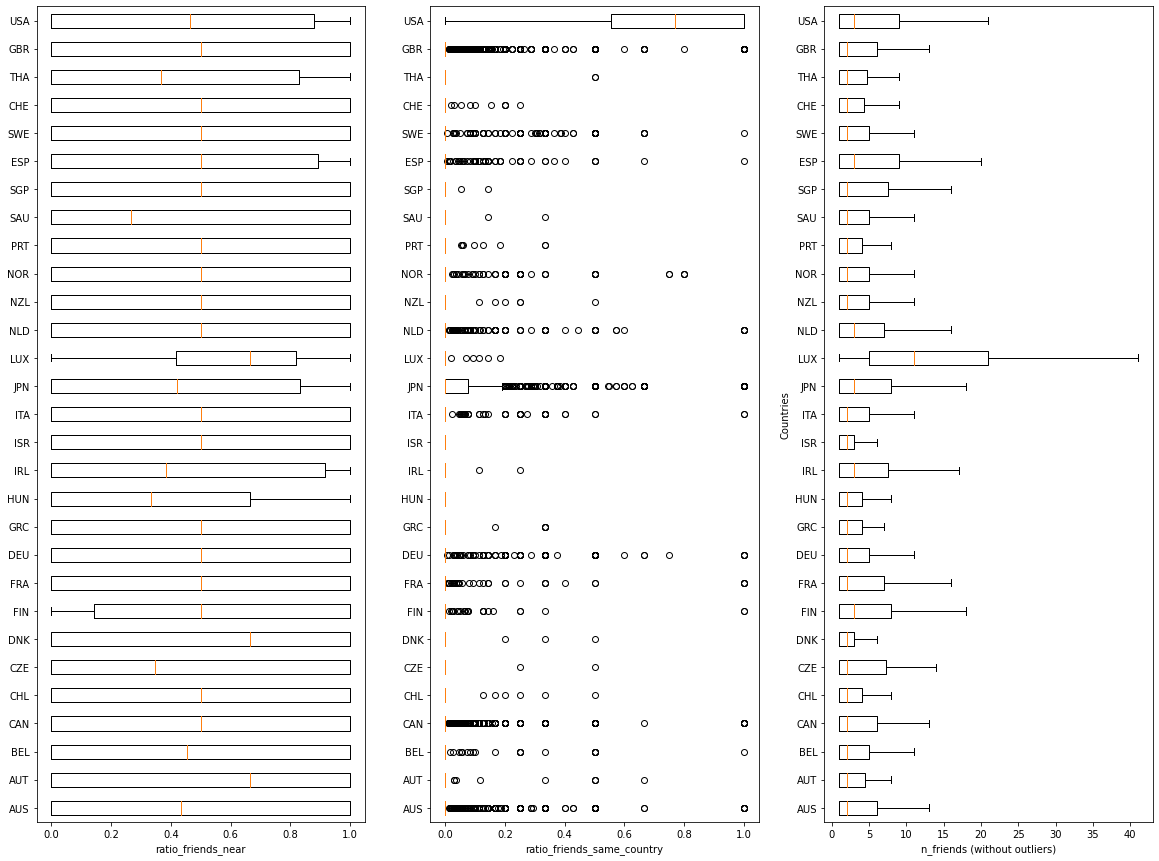

In [51]:
temp = b_friends_all.merge(bright_nat, left_index = True, right_on = "user").dropna()
features = ["ratio_friends_near","ratio_friends_same_country", "n_friends"]

fig, axs = plt.subplots(1, 3, figsize =(20,15))


for i, feature in enumerate(features):
    data = []
    for alpha3 in valid_countries_alpha3:
        users = temp[temp.alpha3 == alpha3]
        data.append(users[feature])
    if i == 2:
        #Impossible to see plots with outliers
        axs[i].boxplot(data,vert=False,showfliers=False)
        axs[i].set_xlabel(feature+" (without outliers)")
    else:
        axs[i].boxplot(data,vert=False,showfliers=True)
        axs[i].set_xlabel(feature)
    axs[i].set_yticks(np.arange(1,len(valid_countries_alpha3)+1))
    axs[i].set_yticklabels(valid_countries_alpha3)
    plt.ylabel("Countries")
plt.show()

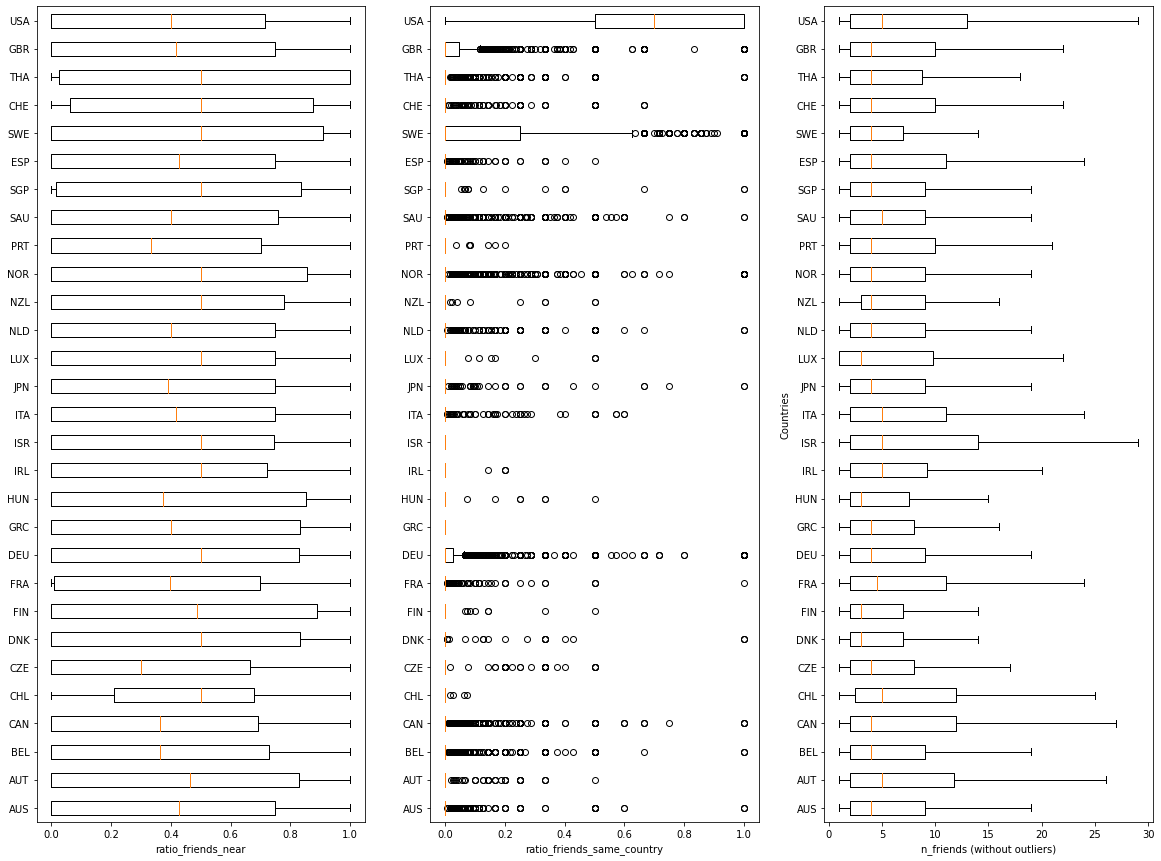

In [52]:
temp = g_friends_all.merge(gowalla_nat, left_index = True, right_on = "user").dropna()
features = ["ratio_friends_near","ratio_friends_same_country", "n_friends"]

fig, axs = plt.subplots(1, 3, figsize =(20,15))


for i, feature in enumerate(features):
    data = []
    for alpha3 in valid_countries_alpha3:
        users = temp[temp.alpha3 == alpha3]
        data.append(users[feature])
    
    if i == 2:
        #Impossible to see plots with outliers
        axs[i].boxplot(data,vert=False,showfliers=False)
        axs[i].set_xlabel(feature+" (without outliers)")
    else:
        axs[i].boxplot(data,vert=False,showfliers=True)
        axs[i].set_xlabel(feature)
    axs[i].set_yticks(np.arange(1,len(valid_countries_alpha3)+1))
    axs[i].set_yticklabels(valid_countries_alpha3)
    
    plt.ylabel("Countries")
plt.show()

For the qualitative features,there a lot of nearly 0 value.

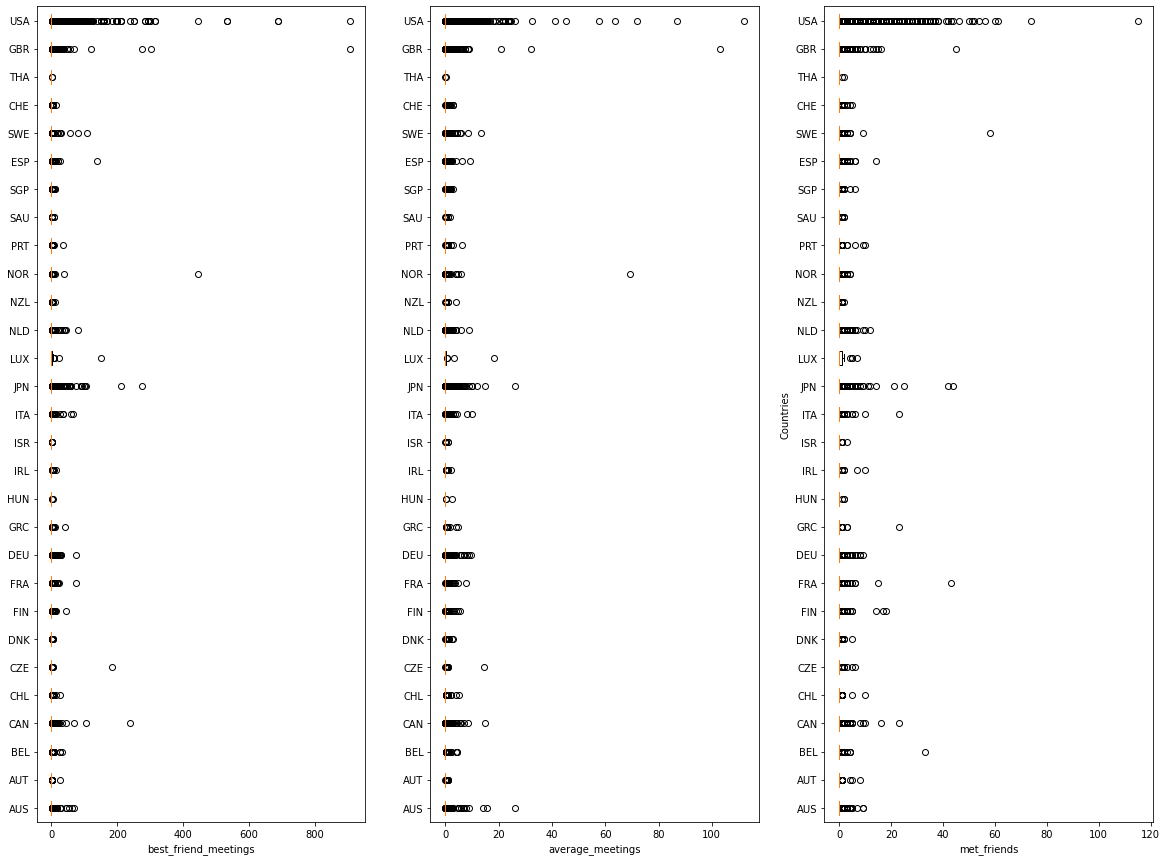

In [53]:
temp = b_friends_all.merge(bright_nat, left_index = True, right_on = "user").dropna()
features = ["best_friend_meetings","average_meetings","met_friends"]

fig, axs = plt.subplots(1, 3, figsize =(20,15))

for i, feature in enumerate(features):
    data = []
    for alpha3 in valid_countries_alpha3:
        users = temp[temp.alpha3 == alpha3]
        data.append(users[feature])
    #Impossible to see plots with outliers
    axs[i].boxplot(data,vert=False,showfliers=True)
    axs[i].set_yticks(np.arange(1,len(valid_countries_alpha3)+1))
    axs[i].set_yticklabels(valid_countries_alpha3)
    axs[i].set_xlabel(feature)
    plt.ylabel("Countries")
plt.show()


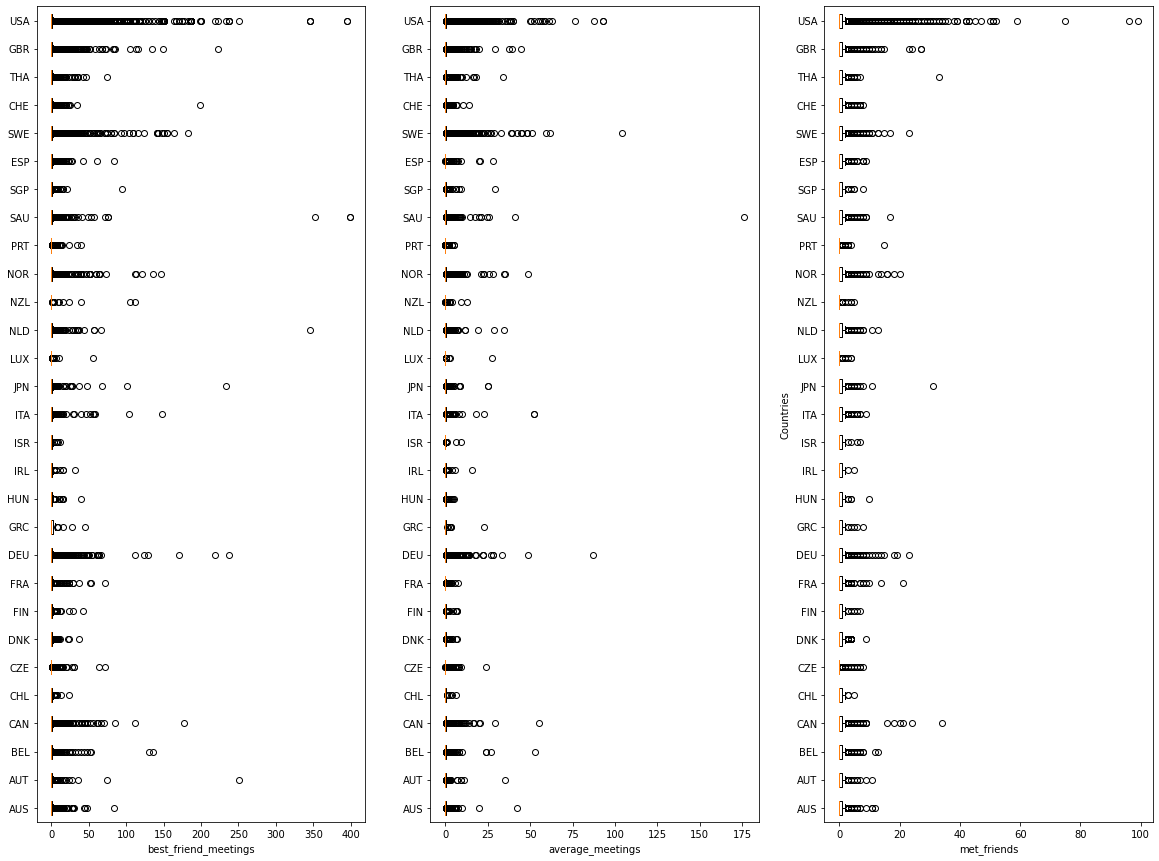

In [54]:
temp = g_friends_all.merge(gowalla_nat, left_index = True, right_on = "user").dropna()
features = ["best_friend_meetings","average_meetings","met_friends"]

fig, axs = plt.subplots(1, 3, figsize =(20,15))

for i, feature in enumerate(features):
    data = []
    for alpha3 in valid_countries_alpha3:
        users = temp[temp.alpha3 == alpha3]
        data.append(users[feature])
        
    axs[i].boxplot(data,vert=False,showfliers=True)
    axs[i].set_xlabel(feature)
    axs[i].set_yticks(np.arange(1,len(valid_countries_alpha3)+1))
    axs[i].set_yticklabels(valid_countries_alpha3)
    plt.ylabel("Countries")
plt.show()


#### 3.4.2 Compare the mean of each country

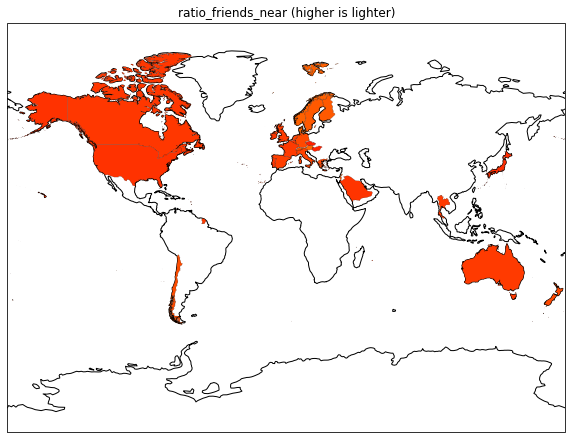

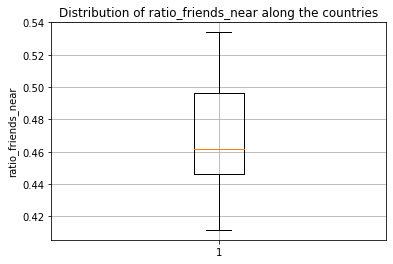

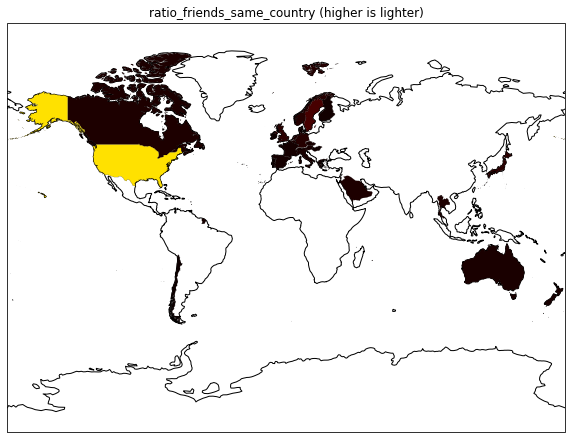

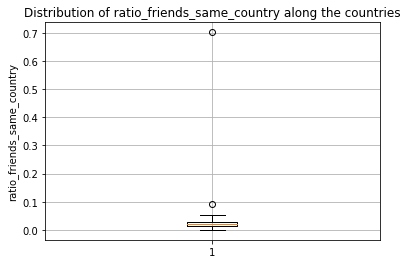

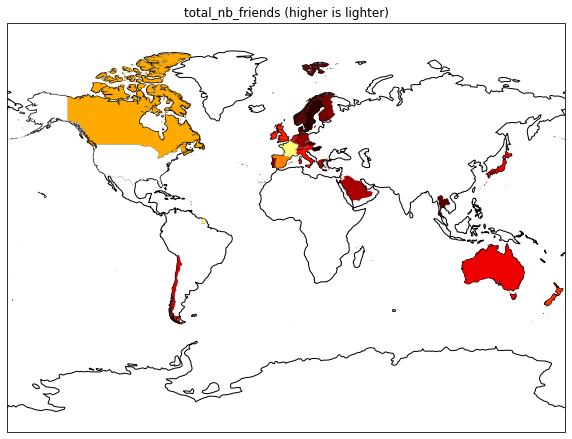

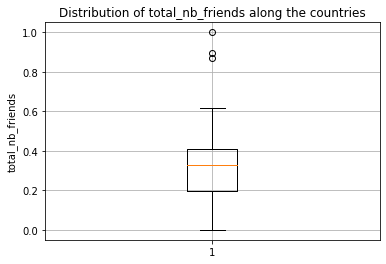

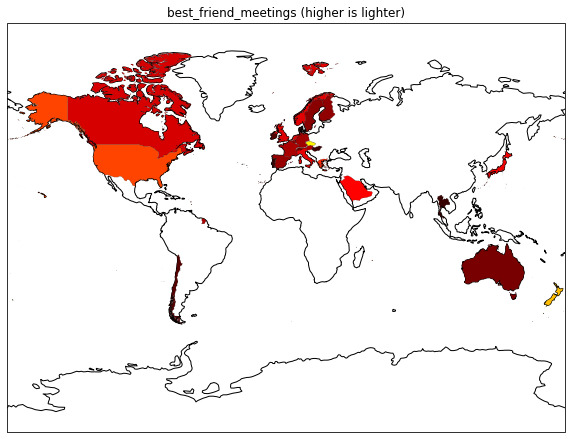

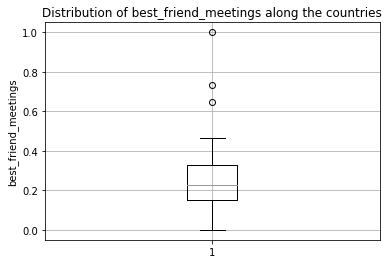

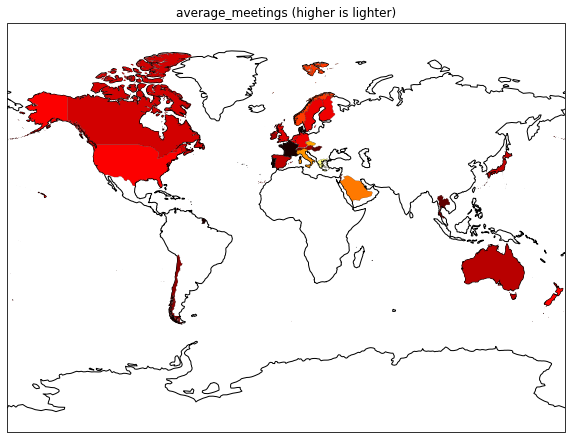

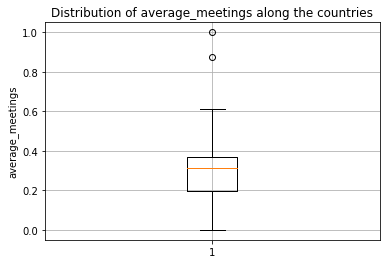

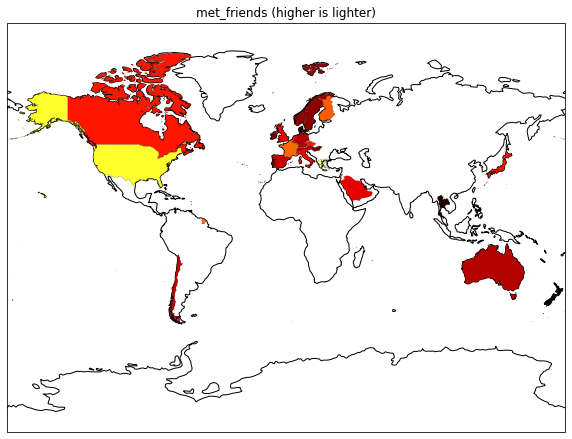

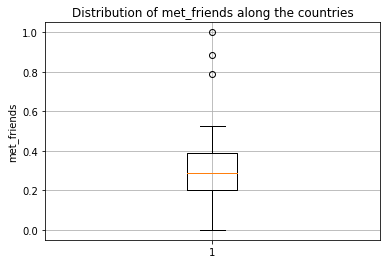

In [55]:
#Min max the value to be printable
scaler = MinMaxScaler()
temp = countries_friendships_0_1.copy()

features = ["ratio_friends_near","ratio_friends_same_country", "total_nb_friends","best_friend_meetings","average_meetings","met_friends"]

for feature in features:
    #Create the world for the plot
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.Miller())
    ax.add_feature(cfeature.COASTLINE)

    #Plot all countries
    for i in range(0, temp.shape[0]) :
        color = cm.hot(temp.iloc[i][feature])
        area(ax, temp.iloc[i].alpha3, color)

    plt.title(feature+" (higher is lighter)")
    plt.show()
    
    plt.grid()
    plt.boxplot(temp[feature])
    plt.ylabel(feature)
    plt.title("Distribution of "+feature+" along the countries")
    plt.show()

### 3.5 Cluster the friendship informations

In [56]:
#Save id of countries
f_countries_alpha3 =  countries_friendships_std.alpha3

#Remove useless information
TO_REMOVE = ["alpha3"]
countries_friendships = countries_friendships_std.drop(columns = TO_REMOVE)

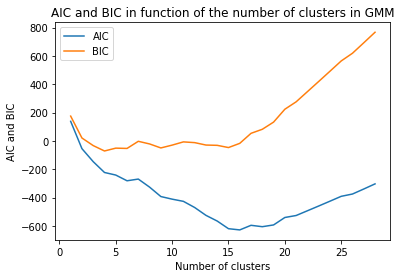

In [57]:
#Initialize the variables
all_aic = []
all_bic = []
NB_MAX_CENTROIDS = countries_friendships.shape[0]

#Evaluate the root mean square (RMS) with different values of k
for nb_centroids in range(1, NB_MAX_CENTROIDS):
    gmm = GaussianMixture(n_components=nb_centroids, n_init = 50, init_params = "kmeans").fit(countries_friendships)
    all_aic.append(gmm.aic(countries_friendships))
    all_bic.append(gmm.bic(countries_friendships))
    
    
#Plot the result
plt.plot(np.arange(1,NB_MAX_CENTROIDS), all_aic, label = "AIC")
plt.plot(np.arange(1,NB_MAX_CENTROIDS), all_bic, label = "BIC")
plt.title("AIC and BIC in function of the number of clusters in GMM")
plt.xlabel("Number of clusters")
plt.ylabel("AIC and BIC")
plt.legend()

The minimum for both metrics is around 16 clusters. That means that the friendships charachteristics are really different from a country to another and that only of few of them can be related.

In [58]:
#Compute with our best resut
BEST_NB_CLUSTERS = 16
gmm = GaussianMixture(n_components=BEST_NB_CLUSTERS, n_init = 100)
labels = gmm.fit_predict(countries_friendships)
res = pd.DataFrame(index = f_countries_alpha3, data = labels, columns =["labels"])

#Print the countries in each cluster
for lab in np.unique(labels):
    print("Label n°"+str(lab))
    print(res[res.labels == lab].index.values)
    
f_friendships_clusters = res

Label n°0
['CHE' 'CHL' 'ISR']
Label n°1
['GRC']
Label n°2
['GBR' 'JPN' 'NLD']
Label n°3
['LUX']
Label n°4
['USA']
Label n°5
['NOR' 'SWE']
Label n°6
['FRA']
Label n°7
['NZL']
Label n°8
['CZE']
Label n°9
['FIN']
Label n°10
['DNK' 'PRT']
Label n°11
['BEL' 'DEU' 'SGP']
Label n°12
['ITA' 'SAU']
Label n°13
['HUN' 'THA']
Label n°14
['CAN' 'ESP']
Label n°15
['AUS' 'AUT' 'IRL']


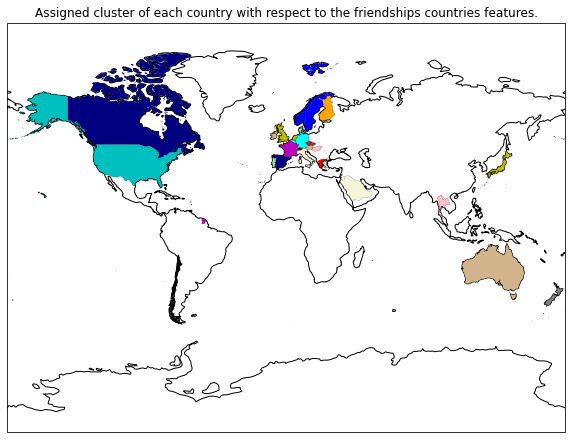

In [59]:
#Create the world for the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

#Extract the clusters
clusters = np.unique(labels)
nb_cluster = np.max(clusters)

#Plot
if(nb_cluster > NB_MAX_GRP): #Some clusters cannot be plotted
    print("COLORS ARE REPEATING")
else:
    for i in range(0, len(labels)) :
        label = labels[i]
        color = color_names[label]
        area(ax, f_countries_alpha3.iloc[i], color)

    plt.title("Assigned cluster of each country with respect to the friendships countries features.")

### 3.6 Verify the statistical difference
Only on the valid countries

#### 3.5.1 Anova test 
Standard ANOVA takes as null hypothesis that all the groups distribution are the same. We assume normal distribution and independence.

In [60]:
print("\nQUANTITATIVE FEATURES\n")

b_temp = bright_friends_nat.copy()
g_temp = gowalla_friends_nat.copy()
b_temp = b_temp[b_temp.alpha3.isin(valid_countries_alpha3)]
g_temp = g_temp[g_temp.alpha3.isin(valid_countries_alpha3)]

datasets = [b_temp, g_temp]
features = ["ratio_friends_near","ratio_friends_same_country","n_friends"]

for feature in features:
    print("\nFeature: "+feature+"\n")
    for dataset in datasets:
        dataset.alpha3 = dataset.alpha3.astype(str)
        res = stat()
        res.anova_stat(df=dataset, res_var=feature, anova_model=feature+' ~ C(alpha3)')
        print(res.anova_summary)


QUANTITATIVE FEATURES


Feature: ratio_friends_near

                df       sum_sq   mean_sq         F        PR(>F)
C(alpha3)     28.0    14.358580  0.512806  3.187121  2.670335e-08
Residual   41010.0  6598.491258  0.160900       NaN           NaN
                df       sum_sq   mean_sq         F        PR(>F)
C(alpha3)     28.0    58.023691  2.072275  15.21442  2.018872e-72
Residual   55994.0  7626.642770  0.136205       NaN           NaN

Feature: ratio_friends_same_country

                df       sum_sq     mean_sq            F  PR(>F)
C(alpha3)     28.0  4302.271480  153.652553  2350.493236     0.0
Residual   41010.0  2680.837832    0.065370          NaN     NaN
                df       sum_sq     mean_sq            F  PR(>F)
C(alpha3)     28.0  5243.482492  187.267232  3761.112414     0.0
Residual   55994.0  2787.962769    0.049790          NaN     NaN

Feature: n_friends

                df        sum_sq     mean_sq         F        PR(>F)
C(alpha3)     28.0  1.309215e+05

In [99]:
print("\nQUALITATIVE FEATURES\n")

b_temp = bright_friends_nat.copy()
g_temp = gowalla_friends_nat.copy()
b_temp = b_temp[b_temp.alpha3.isin(valid_countries_alpha3)]
g_temp = g_temp[g_temp.alpha3.isin(valid_countries_alpha3)]

datasets = [b_temp, g_temp]
features =  ["best_friend_meetings","average_meetings","met_friends"]

for feature in features:
    print("\nFeature: "+feature+"\n")
    for dataset in datasets:
        dataset.alpha3 = dataset.alpha3.astype(str)
        res = stat()
        res.anova_stat(df=dataset, res_var=feature, anova_model=feature+' ~ C(alpha3)')
        print(res.anova_summary)


QUALITATIVE FEATURES


Feature: best_friend_meetings

                df        sum_sq     mean_sq         F    PR(>F)
C(alpha3)     28.0  6.605468e+03  235.909579  1.400571  0.077609
Residual   41010.0  6.907647e+06  168.438109       NaN       NaN
                df        sum_sq     mean_sq         F        PR(>F)
C(alpha3)     28.0  1.075096e+04  383.962796  3.373533  4.013483e-09
Residual   55994.0  6.373025e+06  113.816218       NaN           NaN

Feature: average_meetings

                df        sum_sq   mean_sq         F    PR(>F)
C(alpha3)     28.0     39.848915  1.423176  0.678298  0.898322
Residual   41010.0  86045.348159  2.098155       NaN       NaN
                df         sum_sq   mean_sq         F    PR(>F)
C(alpha3)     28.0     163.856041  5.852001  0.993352  0.474368
Residual   55994.0  329869.878072  5.891165       NaN       NaN

Feature: met_friends

                df         sum_sq    mean_sq         F        PR(>F)
C(alpha3)     28.0     344.400615  12.3000

Except for the last computation we see that the features are statistically different.

The last one means that the number of friends in the Gowalla dataset is statistically not different accors countries (if our hypotheses maintain).

#### 3.5.2 Kruskal-Wallis test
The normal distribution is maybe a too strong assumption for our data, so we do the same but with the Kruskal-Wallis test that assume less than ANVOVA. In this case the null hypothesis is that the median is the same for all.

In [62]:
print("\nQUANTITATIVE FEATURES\n")

b_temp = bright_friends_nat.copy()
g_temp = gowalla_friends_nat.copy()
b_temp = b_temp[b_temp.alpha3.isin(valid_countries_alpha3)]
g_temp = g_temp[g_temp.alpha3.isin(valid_countries_alpha3)]

datasets = [b_temp, g_temp]
features = ["ratio_friends_near","ratio_friends_same_country","n_friends"]

for feature in features:    
    print("\nFeature: "+feature+"\n")
    for dataset in datasets:
        temp = []
        alpha3s = dataset.alpha3.unique()
        for alpha3 in alpha3s:
            temp.append(dataset[dataset.alpha3 == alpha3][feature])
        print(stats.kruskal(temp[0], temp[1],temp[2],temp[3],temp[4],temp[5],temp[6],temp[7],temp[8],temp[9],temp[10],temp[11],temp[12],temp[13],temp[14],temp[15],temp[16],temp[17],temp[18],temp[19],temp[20],temp[21],temp[22],temp[23],temp[24],temp[25],temp[26],temp[27]))


QUANTITATIVE FEATURES


Feature: ratio_friends_near

KruskalResult(statistic=75.39910272399464, pvalue=1.8436052636549212e-06)
KruskalResult(statistic=356.0000632204386, pvalue=4.20835236702664e-59)

Feature: ratio_friends_same_country

KruskalResult(statistic=22716.70128810002, pvalue=0.0)
KruskalResult(statistic=35859.79181977424, pvalue=0.0)

Feature: n_friends

KruskalResult(statistic=693.2296138742482, pvalue=9.953141842931387e-129)
KruskalResult(statistic=1011.6950076656454, pvalue=7.783523600085472e-196)


In [63]:
print("\nQUALITATIVE FEATURES\n")

b_temp = bright_friends_nat.copy()
g_temp = gowalla_friends_nat.copy()
b_temp = b_temp[b_temp.alpha3.isin(valid_countries_alpha3)]
g_temp = g_temp[g_temp.alpha3.isin(valid_countries_alpha3)]

datasets = [b_temp, g_temp]
features = ["best_friend_meetings","average_meetings","met_friends"]

for feature in features:    
    print("\nFeature: "+feature+"\n")
    for dataset in datasets:
        temp = []
        alpha3s = dataset.alpha3.unique()
        for alpha3 in alpha3s:
            temp.append(dataset[dataset.alpha3 == alpha3][feature])
        print(stats.kruskal(temp[0], temp[1],temp[2],temp[3],temp[4],temp[5],temp[6],temp[7],temp[8],temp[9],temp[10],temp[11],temp[12],temp[13],temp[14],temp[15],temp[16],temp[17],temp[18],temp[19],temp[20],temp[21],temp[22],temp[23],temp[24],temp[25],temp[26],temp[27]))


QUALITATIVE FEATURES


Feature: best_friend_meetings

KruskalResult(statistic=140.28173203341618, pvalue=2.9066201459694084e-17)
KruskalResult(statistic=156.22246274465184, pvalue=3.7759582620939415e-20)

Feature: average_meetings

KruskalResult(statistic=125.71104670228503, pvalue=1.1030893921807578e-14)
KruskalResult(statistic=90.97080670997956, pvalue=7.4328975464380626e-09)

Feature: met_friends

KruskalResult(statistic=143.81764794395565, pvalue=6.737402617494901e-18)
KruskalResult(statistic=184.7591145868547, pvalue=1.9008440533578052e-25)


Once more the features seems to be statistically different. And that maybe the last conclusion of ANOVA statitics was uncorrect due to the wrong hypotheses.

## 4. Analyze the data

### 4.0 Preprocess

Some of the features have an space that cannot be interpreted by the function because they have spaces in their names. A dictionary is created and applied to avoid this error:

In [94]:
countries_reg = countries_all_features.copy()

In [103]:
friendship_features_names = ["ratio_friends_near","ratio_friends_same_country","total_nb_friends", "best_friend_meetings","average_meetings","met_friends"]

In [95]:
countries_reg.rename(columns = {
 'Population density (per km2, 2017)' : "Population_density",
 'Sex ratio (m per 100 f, 2017)' : 'Sex_ratio',
 'GDP growth rate (annual %, const. 2005 prices)' : 'GPD_growth_rate',
 'GDP per capita (current US$)' : 'GDP_per_capita',
 'Labour force participation (female/male pop. %)': 'Labour_force_participation',
 'Population growth rate (average annual %)' : 'Population_growth_rate',
 'Urban population (% of total population)' : 'Urban_population',
 'Urban population growth rate (average annual %)' : 'Urban_population_growth_rate',
 'Life expectancy at birth (females/males, years)' : 'Life_expectancy_at_birth',
 'Population age distribution (0-14 / 60+ years, %)' : 'Population_age_distribution',
 'International migrant stock (000/% of total pop.)' : 'International_migrant_stock',
 'Health: Total expenditure (% of GDP)' : 'Heath_total_expenditure',
 'Education: Primary gross enrol. ratio (f/m per 100 pop.)' : 'Education_Primary',
 'Education: Secondary gross enrol. ratio (f/m per 100 pop.)' : 'Education_Secondary',
 'Education: Tertiary gross enrol. ratio (f/m per 100 pop.)' : 'Education_Tertiary',
 'Individuals using the Internet (per 100 inhabitants)' : 'Individuals_using_the_Internet',
 'Forested area (% of land area)' : 'Forested_area',
 'Energy supply per capita (Gigajoules)' : 'Energy_supply_per_capita',
 'Coastline (coast/area ratio)' : 'Coastline'}, inplace = True)

In [96]:
Features = ['Population_growth_rate','Urban_population_growth_rate','Population_density', 'Coastline', 'GPD_growth_rate']
for feature in Features:
    countries_reg[feature] = countries_reg[feature].astype(float)

### 4.1 Correlation matrix and pairplot

In [104]:
corr = countries_reg.corr()
corr = corr[friendship_features_names]
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,ratio_friends_near,ratio_friends_same_country,total_nb_friends,best_friend_meetings,average_meetings,met_friends
ratio_friends_near,1.00,-0.17,0.03,0.03,0.13,0.06
ratio_friends_same_country,-0.17,1.00,0.49,0.19,0.05,0.37
total_nb_friends,0.03,0.49,1.00,0.43,0.18,0.60
best_friend_meetings,0.03,0.19,0.43,1.00,0.80,0.60
average_meetings,0.13,0.05,0.18,0.80,1.00,0.68
met_friends,0.06,0.37,0.60,0.60,0.68,1.00
happiness_score,0.51,0.06,0.08,0.10,-0.07,-0.09
social_support,0.24,0.00,0.06,-0.11,-0.41,-0.38
freedom_of_choices,0.34,0.03,-0.03,-0.01,-0.27,-0.36
generosity,0.32,0.20,0.14,-0.13,-0.22,-0.32


Interesting points: (only consider > 0.5 correlation)

Correlations btw friendships charachs:
1. nb friends <-> total nb friends
2. best friend meeting  <->  total meeting  <-> met friends
3. met friends <-> total nb friends

Correlations with ratio_friends_near:
1. happiness_score (invers effect ? people are happy bcs friends are near)
2. perception_of_corruption (?)
3. GDP_per_capita (more urbanized)

Correlations with ratio_friends_same_country:
1. International_migrant_stock (people are not in the country)
2. Heath_total_expenditure (maybe influence migration)
3. Individuals_using_the_Internet (?)
4. Forested_area (? few friends near so more okay to find worlwide friends)

Correlations with total_nb_friends:
1. International_migrant_stock (?)
2. Forested_area (?)

Coorelations with all qualitatives -> DO NOT HAVE BIGGER THAN 50 -> quality does not change

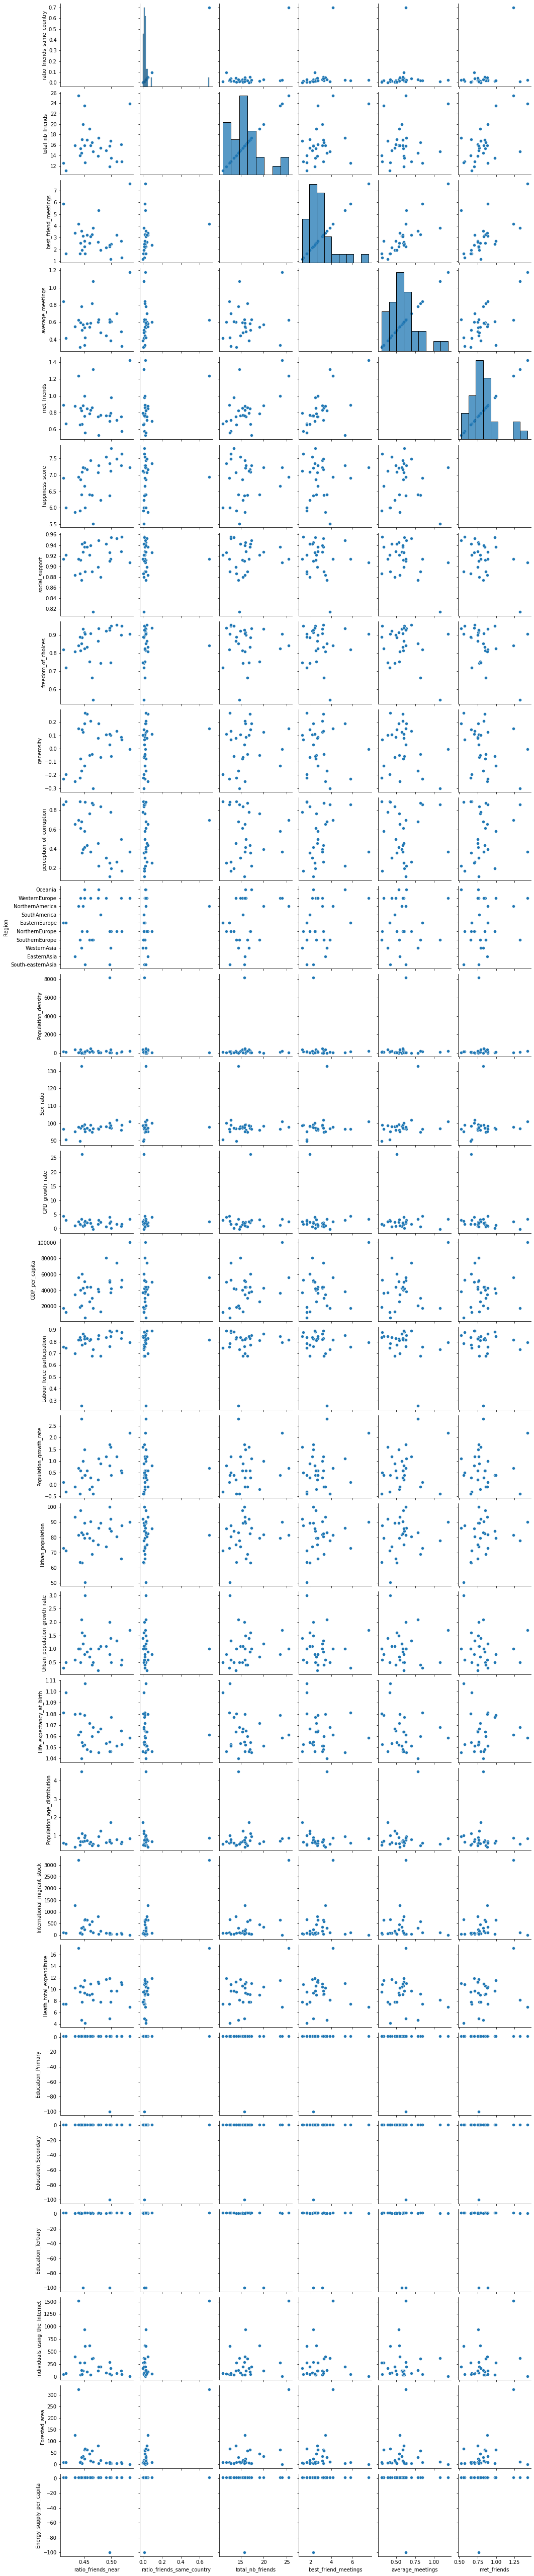

In [126]:
sns.pairplot(countries_reg,x_vars=["ratio_friends_near", "ratio_friends_same_country", "total_nb_friends", "best_friend_meetings", "average_meetings", "met_friends"],
            y_vars = countries_reg.columns[2:-1])

Most of the plots seem to be random, although some seem to have a "tendency" like influence of near friends on happiness.

### 4.2 Regression
Need to see to which extent our previous conclusion are verified

#### 4.2.1 Happiness influenced by friendship charachteristics

In [112]:
mod = smf.ols(formula = 'happiness_score ~ ratio_friends_near + ratio_friends_same_country + total_nb_friends', data = countries_all_features_std)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        happiness_score   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     3.225
Date:                Thu, 17 Dec 2020   Prob (F-statistic):             0.0396
Time:                        09:40:16   Log-Likelihood:                -36.406
No. Observations:                  29   AIC:                             80.81
Df Residuals:                      25   BIC:                             86.28
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

R^2 is not that high. But we see that the influence on happiness from the proximity of friends is confirmed

### 4.2.2 Friends near depending on all country features

In [121]:
mod = smf.ols(formula='ratio_friends_near ~ happiness_score + \
 social_support + freedom_of_choices + generosity + perception_of_corruption + \
 Population_density + Sex_ratio + GPD_growth_rate + GDP_per_capita + Labour_force_participation + \
 Population_growth_rate + Urban_population + Urban_population_growth_rate + Life_expectancy_at_birth + \
 Population_age_distribution + International_migrant_stock + Heath_total_expenditure + Education_Primary + \
 Education_Secondary + Education_Tertiary + Individuals_using_the_Internet + Forested_area + Energy_supply_per_capita + \
 Coastline', data=countries_all_features_std.drop(columns = ["Region"]))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     ratio_friends_near   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.029
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.559
Time:                        09:47:10   Log-Likelihood:                -12.582
No. Observations:                  29   AIC:                             75.16
Df Residuals:                       4   BIC:                             109.3
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

We can say nothing about the results due to the p-values.

### 4.2.3 Friends in the same country depending on all country features

In [127]:
mod = smf.ols(formula='ratio_friends_same_country ~ happiness_score + \
 social_support + freedom_of_choices + generosity + perception_of_corruption + \
 Population_density + Sex_ratio + GPD_growth_rate + GDP_per_capita + Labour_force_participation + \
 Population_growth_rate + Urban_population + Urban_population_growth_rate + Life_expectancy_at_birth + \
 Population_age_distribution + International_migrant_stock + Heath_total_expenditure + Education_Primary + \
 Education_Secondary + Education_Tertiary + Individuals_using_the_Internet + Forested_area + Energy_supply_per_capita + \
 Coastline', data=countries_all_features_std.drop(columns = ["Region"]))
res = mod.fit()
print(res.summary())

                                OLS Regression Results                                
Dep. Variable:     ratio_friends_same_country   R-squared:                       0.989
Model:                                    OLS   Adj. R-squared:                  0.925
Method:                         Least Squares   F-statistic:                     15.33
Date:                        Thu, 17 Dec 2020   Prob (F-statistic):            0.00834
Time:                                09:56:51   Log-Likelihood:                 24.568
No. Observations:                          29   AIC:                            0.8650
Df Residuals:                               4   BIC:                             35.05
Df Model:                                  24                                         
Covariance Type:                    nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

Forested area, population density, migrant stock and corruption seem to have an influence. With less certitude: appiness, labour force participation urban population and energy supply.

### 4.2.3 Total number of friends depending on all country features

In [130]:
mod = smf.ols(formula='total_nb_friends ~ happiness_score + \
 social_support + freedom_of_choices + generosity + perception_of_corruption + \
 Population_density + Sex_ratio + GPD_growth_rate + GDP_per_capita + Labour_force_participation + \
 Population_growth_rate + Urban_population + Urban_population_growth_rate + Life_expectancy_at_birth + \
 Population_age_distribution + International_migrant_stock + Heath_total_expenditure + Education_Primary + \
 Education_Secondary + Education_Tertiary + Individuals_using_the_Internet + Forested_area + Energy_supply_per_capita + \
 Coastline', data=countries_all_features_std.drop(columns = ["Region"]))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       total_nb_friends   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1.065
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.542
Time:                        10:00:18   Log-Likelihood:                -12.145
No. Observations:                  29   AIC:                             74.29
Df Residuals:                       4   BIC:                             108.5
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

With low certitude: social support, generosity, corruption and sec ratio may have an influence.

### 4.2.4 Number of best friends meeting depending on all country features

In [131]:
mod = smf.ols(formula='best_friend_meetings ~ happiness_score + \
 social_support + freedom_of_choices + generosity + perception_of_corruption + \
 Population_density + Sex_ratio + GPD_growth_rate + GDP_per_capita + Labour_force_participation + \
 Population_growth_rate + Urban_population + Urban_population_growth_rate + Life_expectancy_at_birth + \
 Population_age_distribution + International_migrant_stock + Heath_total_expenditure + Education_Primary + \
 Education_Secondary + Education_Tertiary + Individuals_using_the_Internet + Forested_area + Energy_supply_per_capita + \
 Coastline', data=countries_all_features_std.drop(columns = ["Region"]))
res = mod.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     best_friend_meetings   R-squared:                       0.828
Model:                              OLS   Adj. R-squared:                 -0.202
Method:                   Least Squares   F-statistic:                    0.8038
Date:                  Thu, 17 Dec 2020   Prob (F-statistic):              0.681
Time:                          10:03:34   Log-Likelihood:                -15.604
No. Observations:                    29   AIC:                             81.21
Df Residuals:                         4   BIC:                             115.4
Df Model:                            24                                         
Covariance Type:              nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

Nothing can be said, just that maybe population density has an influence.

### 4.2.5 Average meetings depending on all country features

In [132]:
mod = smf.ols(formula='average_meetings ~ happiness_score + \
 social_support + freedom_of_choices + generosity + perception_of_corruption + \
 Population_density + Sex_ratio + GPD_growth_rate + GDP_per_capita + Labour_force_participation + \
 Population_growth_rate + Urban_population + Urban_population_growth_rate + Life_expectancy_at_birth + \
 Population_age_distribution + International_migrant_stock + Heath_total_expenditure + Education_Primary + \
 Education_Secondary + Education_Tertiary + Individuals_using_the_Internet + Forested_area + Energy_supply_per_capita + \
 Coastline', data=countries_all_features_std.drop(columns = ["Region"]))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       average_meetings   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     2.005
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.263
Time:                        10:04:27   Log-Likelihood:                -3.9243
No. Observations:                  29   AIC:                             57.85
Df Residuals:                       4   BIC:                             92.03
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Nothing can be said, just maybe that age density and forested area may influence

### 4.2.6 Total number of meetings with friends depending on all country features

In [133]:
mod = smf.ols(formula='met_friends ~ happiness_score + \
 social_support + freedom_of_choices + generosity + perception_of_corruption + \
 Population_density + Sex_ratio + GPD_growth_rate + GDP_per_capita + Labour_force_participation + \
 Population_growth_rate + Urban_population + Urban_population_growth_rate + Life_expectancy_at_birth + \
 Population_age_distribution + International_migrant_stock + Heath_total_expenditure + Education_Primary + \
 Education_Secondary + Education_Tertiary + Individuals_using_the_Internet + Forested_area + Energy_supply_per_capita + \
 Coastline', data=countries_all_features_std.drop(columns = ["Region"]))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            met_friends   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     2.799
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.164
Time:                        10:06:01   Log-Likelihood:                0.59523
No. Observations:                  29   AIC:                             48.81
Df Residuals:                       4   BIC:                             82.99
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Nothing can be said, just that maybe freedom of choices, generosity, population density and coastline may influence.

### 4.2.7 Regression conclusion
Few major elements -> maybe same everywhere. Non-lin regression doesn't seem necessary because the pairplot seem to show that it is random.

## 4.3 PCA

### 4.3.1 PCA on all

In [142]:
# Initialize
model = pca()
    

df_temp = countries_all_features_std.drop(columns = ["Region","alpha3"])
# Fit transform
out = model.fit_transform(df_temp)

# Print the top features. The results show that f1 is best, followed by f2 etc
print(out['topfeat'])

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [30] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
      PC                         feature   loading  type
0    PC1        perception_of_corruption -0.301992  best
1    PC2                 happiness_score -0.363306  best
2    PC3      ratio_friends_same_country  0.374858  best
3    PC4                       Sex_ratio  0.431056  best
4    PC5                average_meetings -0.373030  best
5    PC6                 GPD_growth_rate  0.418777  best
6    PC7                 GPD_growth_rate  0.655201  best
7    PC8              ratio_friends_near -0.418924  best
8    PC9     